<a href="https://colab.research.google.com/github/Woodruff-Scientific-Ltd/PyFECONS/blob/main/MIF/PyCosting_ARPA_E_MIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyFECONS

In [ ]:
repo_name = "PyFECONS"
project = "MIF"
PAT = 'ENTER PAT HERE'
gitusername = "GITHUB USERNAME"
gitemail ="GITHUB EMAIL"

In [ ]:
import os

# Set your GitHub credentials and repository name
os.environ['GITHUB_AUTH'] = PAT

# Clone the repository using the token for authentication
repo_url = f"https://${{GITHUB_AUTH}}@github.com/Woodruff-Scientific-Ltd/{repo_name}"
!git clone {repo_url}
!git pull {repo_url}
!git config --global user.name {gitusername}
!git config --global user.email {gitemail}

# Change directory to the cloned repository using Python command
os.chdir(f'/content/{repo_name}')
!ls

Cloning into 'PyFECONS'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 218 (delta 6), reused 45 (delta 3), pack-reused 161
Receiving objects: 100% (218/218), 4.26 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (55/55), done.
fatal: not a git repository (or any of the parent directories): .git
IFE  MFE  MIF  README.md


# Cost Code
(run from here when making updates)

In [ ]:
#Libraries

materials = {
    "FS": {"rho": 7470, "c_raw": 10, "m": 3, "sigma": 450},
    "Pb": {"rho": 9400, "c_raw": 2.4, "m": 1.5},
    "Li4SiO4": {"rho": 2390, "c_raw": 1, "m": 2},
    "FLiBe": {"rho": 1900, "c": 40},
    "W": {"rho": 19300, "c_raw": 100, "m": 3},
    "Li": {"rho": 534, "c_raw": 70, "m": 1.5},
    "BFS": {"rho": 7800, "c_raw": 30, "m": 2},
    "PbLi": {"rho": None, "c": None},  # To be calculated
    "SiC": {"rho": 3200, "c_raw": 14.49, "m": 3},
    "Inconel": {"rho": 8440, "c_raw": 46, "m": 3},
    "Cu": {"rho": 7300, "c_raw": 10.2, "m": 3},
    "Polyimide": {"rho": 1430, "c_raw": 100, "m": 3},
    "YBCO": {"rho": 6200, "c": 55},
    "Concrete": {"rho": 2300, "c_raw": 13/25, "m": 2},
    "SS316": {"rho": 7860, "c_raw": 2, "m": 2, "sigma": 900},
    "Nb3Sn": {"c": 5},
    "Incoloy": {"rho": 8170, "c_raw": 4, "m": 2},
    "GdBCO": {},
    "He": {},
    "NbTi": {},
    "Be":{"rho": 1850, "c_raw": 5750.00, "m": 3},
    "Li2TiO3":{"rho": 3430, "c_raw": 1297.05, "m": 3},
}

pblir = 10
materials["PbLi"]["rho"] = (materials["Pb"]["rho"] * pblir + materials["Li"]["rho"]) / (pblir + 1)
materials["PbLi"]["c"] = (materials["Pb"]["c_raw"] * materials["Pb"]["m"] * pblir + materials["Li"]["c_raw"] * materials["Li"]["m"]) / (pblir + 1)


blanket = {
    "firstWall": ["tungsten", "liquid lithium", "beryllium", "FLiBe"],
    "blanketType": [
        "flowing liquid first wall",
        "solid first wall with a liquid breeder",
        "solid first wall with a solid breeder (Li4SiO4)",
        "solid first wall with a solid breeder (Li2TiO3)",
        "solid first wall, no breeder (anuetronic fuel)"
    ],
    "primaryCoolant": [
        "Lead Lithium (PbLi)", "Lithium (Li)", "FLiBe",
        "other eutectic salt", "helium",
        "dual coolant: PbLi and He", "water"
    ],
    "secondaryCoolant": [
        "no", "Lead Lithium (PbLi)", "Lithium (Li)", "FLiBe",
        "other eutectic salt", "helium",
        "dual coolant: PbLi and He", "water"
    ],
    "neutronMultiplier": [
        "no", "Be", "Pb", "Pb as part of PbLi", "Be12Ti"
    ],
    "structure": [
        "Stainless Steel (SS)", "Ferritic Martensitic Steel (FMS)",
        "Oxide Dispersion Strengthened (ODS) Steel", "Vanadium"
    ]
}



In [ ]:
#Basic inputs

timetoReplace=10 #years
downTime=1 #years
reactorType=2 #2 is IFE, 1 is MIF, 3 is MIF %input
NMOD=1 #input
AM=1 #input
constructionTime=6 #input
lifeY=30 #lifetime of plant from end of cinstruction
NOAK ="y" #Enter "y" as input if NOAK costing, enter "n" otherwise
yinflation=0.0245 #inflation at 2.45%
p_a = 0.9 #plant availability factor in Miller 2003 was 0.76

firstW = blanket["firstWall"][1]
blanketT = blanket["blanketType"][0]
primaryC = blanket["primaryCoolant"][0]
secondaryC = blanket["secondaryCoolant"][7]
neutronM = blanket["neutronMultiplier"][3]
structure1 = blanket["structure"][1]


In [ ]:
import math
from IPython.display import IFrame
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LinearNDInterpolator
from collections import OrderedDict
import re
from math import log10, floor
from scipy.interpolate import LinearNDInterpolator
from sklearn.linear_model import LinearRegression
import shutil

In [ ]:
#Overwriting function
#1)Reads file from 'Originals' directory
#2)Generates copy
#3)Searches copy for placeholders
#4)Overwrites placeholders in copy
#5)Saves copied and overwritten file into 'Modified' directory

base_directory = f"/content/{repo_name}/{project}"
original_directory = os.path.join(base_directory, "Originals")
modified_directory = os.path.join(base_directory, "Modified")
figures_directory = os.path.join(base_directory, "Figures")


def copy_file(filename):
    """
    Copy the file from the original directory to the modified directory.
    """
    original_path = os.path.join(original_directory, filename)
    modified_path = os.path.join(modified_directory, filename)

    try:
        shutil.copyfile(original_path, modified_path)
        print(f"Copied {original_path} to {modified_path}.")
    except FileNotFoundError:
        print(f"The file '{original_path}' does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

def overwrite_variable(filename, variable, value):
    """
    Replace a specified variable with the given value in a file within the modified directory.
    The value can be a number or a string.
    """
    modified_path = os.path.join(modified_directory, filename)

    try:
        with open(modified_path, 'r') as file:
            content = file.read()

        # Check if value is nan (using numpy's isnan function) and replace with '-'
        if isinstance(value, float) and np.isnan(value):
            replacement = '-'
        else:
            replacement = str(value)

        content = content.replace(variable, replacement)

        with open(modified_path, 'w') as file:
            file.write(content)

        print(f"Replaced '{variable}' with '{replacement}' in '{modified_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Function to safely round values
def safe_round(value, decimals):
    if isinstance(value, float):
        return round(value, decimals)
    return value


def round_to_2(x):
    # Ensure x is a float before checking for np.isnan
    if isinstance(x, float) and np.isnan(x):
        return np.nan
    # Process as float for numerical rounding logic
    elif isinstance(x, (float, int)) and x != 0:
        return round(float(x), 1 - int(floor(log10(abs(x)))))
    else:
        # Directly return x for 0 or non-numeric types that don't need rounding
        return x

In [ ]:
#power balance

#MCF
PNRL = 2600  # Fusion Power
PALPHA = PNRL * 3.52 / 17.58  # Charged particle power
PNEUTRON = PNRL - PALPHA  # Neutron power
MN = 1.1  # Neutron energy multiplier
ETAP = 0.5  # Pumping power capture efficiency
FPCPPF = 0.06  # Primary Coolant Pumping Power Fraction
FSUB = 0.03  # Subsystem and Control Fraction
PTRIT = 10.00  # Tritium Systems
PHOUSE = 4.00  # Housekeeping power
PTFCOOL = 12.7  # Solenoid coil cooling
PPFCOOL = 11  # Mirror coil cooling
PCOOL=PPFCOOL+PTFCOOL
PTF =  1 # Power into TF coils
PPF = 1  # Power into PF (equilibrium) coils how to handle for HTS??
ETAPIN = 0.5  # Input power wall plug efficiency
ETATH = 0.5  # Thermal conversion efficiency
ETADE  = 0.85 #Direct energy conversion efficiency
PCRYO = 0.8*PNRL/560
PINPUT = 50  # Input power

# Calculate dependent values
PAUX = PTRIT + PHOUSE
PCOILS = PTF + PPF
PTH = MN * PNEUTRON  + PINPUT + ETATH * (FPCPPF * ETAP + FSUB) * (MN * PNEUTRON)
PTHE = ETATH*PTH #Total thermal electric power
PDEE = ETADE*PALPHA
PET = PDEE+PTHE #Gross electric
PLOSS = PTH - PTHE-PDEE
PPUMP = FPCPPF * PTHE
PSUB = FSUB * PTHE
QSCI =  PNRL/ PINPUT
QENG = (ETATH * (MN * PNEUTRON + PPUMP + PINPUT)+ETADE*PALPHA) / (PCOILS + PPUMP + PSUB + PAUX + PCOOL+PCRYO + PINPUT / ETAPIN)
REFRAC = 1 / QENG
PNET = (1 - 1 / QENG) * PET


PT_dict = {
    'PNRL': PNRL, 'PALPHA': PALPHA, 'PNEUTRON': PNEUTRON, 'MN': MN, 'ETAPIN': ETAPIN,
    'FPCPPF': FPCPPF, 'FSUB': FSUB, 'PTRIT': PTRIT, 'PHOUSE': PHOUSE, 'PTFCOOL': PTFCOOL, 'PPFCOOL': PPFCOOL,'PCOOL': PCOOL,
    'PINPUT': PINPUT, 'PTF': PTF, 'PPF': PPF, 'ETAP': ETAP, 'ETATH': ETATH, 'PAUX': PAUX,
    'PCRYO': PCRYO, 'PCOILS': PCOILS,'PTHE':PTHE, 'ETADE':ETADE, 'PDEE':PDEE, 'PTH': PTH, 'PET': PET, 'PLOSS': PLOSS, 'PPUMP': PPUMP,
    'PSUB': PSUB, 'QSCI': QSCI, 'QENG': QENG, 'REFRAC': REFRAC, 'PNET': PNET, 'REFRAC':REFRAC
}

# Loop through the dictionary and overwrite each variable
copy_file('powerTableMIFDT.tex')
for var_name, var_value in PT_dict.items():
    overwrite_variable('powerTableMIFDT.tex', var_name, round(var_value,1))

Copied /content/PyFECONS/MIF/Originals/powerTableMIFDT.tex to /content/PyFECONS/MIF/Modified/powerTableMIFDT.tex.
Replaced 'PNRL' with '2600' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'PALPHA' with '520.6' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'PNEUTRON' with '2079.4' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'MN' with '1.1' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'ETAPIN' with '0.5' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'FPCPPF' with '0.1' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'FSUB' with '0.0' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'PTRIT' with '10.0' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'PHOUSE' with '4.0' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'PTFCOOL' with '12.7' in '/content/PyFECONS/MIF/Modified/powerTableMIFDT.tex'.
Replaced 'PPFCOOL' with 

In [ ]:
#Cost Category 10: Pre-construction Costs

#Cost Category 11: Land and Land Rights

C110000 = np.sqrt(NMOD) * (PNEUTRON /239 * 0.9 + PNRL/239*0.9)

#Cost Category 12 – Site Permits

C120000 = 10

#Cost Category 13 – Plant Licensing
# https://world-nuclear.org/information-library/economic-aspects/economics-of-nuclear-power.aspx

C130000 = 200

#Cost Category 14 – Plant Permits

C140000 = 5

#Cost Category 15 – Plant Studies

C150000 = 5

#Cost Category 16 – Plant Reports

C160000 = 2

#Cost Category 17 – Other Pre-Construction Costs

C170000 = 1

#Cost Cetegory 19 - Contingency

if NOAK =="y":
  C190000 = 0
else:
  C190000 = 0.1 * (C110000 + C120000 + C130000 + C140000 + C150000 + C160000 + C170000)

#Cost Category 10

C100000 = C110000 + C120000 + C130000 + C140000 + C150000 + C160000 + C170000

copy_file('CAS100000.tex')
overwrite_variable('CAS100000.tex', 'Nmod', NMOD)
overwrite_variable('CAS100000.tex', 'C100000', round(C100000))
overwrite_variable('CAS100000.tex', 'C110000', round(C110000))
overwrite_variable('CAS100000.tex', 'C120000', round(C120000))
overwrite_variable('CAS100000.tex', 'C130000', round(C130000))
overwrite_variable('CAS100000.tex', 'C140000', round(C140000))
overwrite_variable('CAS100000.tex', 'C150000', round(C150000))
overwrite_variable('CAS100000.tex', 'C160000', round(C160000))
overwrite_variable('CAS100000.tex', 'C170000', round(C170000))
overwrite_variable('CAS100000.tex', 'C190000', round(C190000))

Copied /content/PyFECONS/MIF/Originals/CAS100000.tex to /content/PyFECONS/MIF/Modified/CAS100000.tex.
Replaced 'Nmod' with '1' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C100000' with '241' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C110000' with '18' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C120000' with '10' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C130000' with '200' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C140000' with '5' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C150000' with '5' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C160000' with '2' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C170000' with '1' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.
Replaced 'C190000' with '0' in '/content/PyFECONS/MIF/Modified/CAS100000.tex'.


In [ ]:
#Cost Category 21: Buildings

#Buildings come out to be 470$/kW gross, so if we are looking at a gross power of 1GW, we have:


#21.01.00,,Site improvements and facs,,20.7,,,,,2019,1.19,

C210100 = 268/1e3 * PET

#21.02.00,,Fusion Heat Island Building,Concrete & Steel,131.6,48.3,48.3,60,140000,2009,1.42,

C210200 = 186.8/1e3 * PET

#21.03.00,,Turbine building,Steel ,45.3,48.3,48.3,30,70000,2019,1.19,

C210300 = 54.0/1e3 * PET

#21.04.00,,Heat exchanger building,Concrete & Steel,31.7,48.3,48.3,15,35000,2019,1.19,

C210400 = 37.8/1e3 * PET

#21.05.00,,Power supply & energy storage,Concrete & Steel,9.1,9.7,9.7,6.0,560,2019,1.19,

C210500 = 10.8/1e3 * PET
#21.06.00,,Reactor auxiliaries,Concrete & Steel,4.5,4.8,4.8,3.0,70,2019,1.19,

C210600 = 5.4/1e3 * PET

#21.07.00,,Hot cell,Concrete & Steel,65.8,24.2,24.2,60,35000,2013,1.42,

C210700 = 93.4/1e3 * PET

#21.08.00,,Reactor services,Steel frame,13.2,4.8,4.8,10,233,2013,1.42,

C210800 = 18.7/1e3 * PET

#21.09.00,,Service water,Steel frame,0.2,1.3,4.0,4.0,21,2019,1.19,

C210900 = 0.3/1e3 * PET

#21.10.00,,Fuel storage,Steel frame,0.9,5.0,15.0,2.5,188,2019,1.19,

C211000 = 1.1/1e3 * PET

#21.11.00,,Control room,Steel frame,0.7,4.0,12.0,2,96,2019,1.19,

C211100 = 0.9/1e3 * PET

#21.12.00,,Onsite AC power,Steel frame,0.7,3.6,10.8,1.8,70,2019,1.19,

C211200 = 0.8/1e3 * PET

#21.13.00,,Administration,Steel frame,3.7,20.0,60.0,10,12000,2019,1.19,

C211300 = 4.4/1e3 * PET

#21.14.00,,Site services,Steel frame,1.3,7.3,22.0,3.7,593,2019,1.19,

C211400 = 1.6/1e3 * PET

#21.15.00,,Cryogenics,Steel frame,2.0,11.0,33.0,5.5,2003,2019,1.19,

C211500 = 2.4/1e3 * PET

#21.16.00,,Security,Steel frame,0.7,4.0,12.0,2,96,2019,1.19,

C211600 = 0.9/1e3 * PET

#21.17.00,,Ventilation stack,Steel cylinder & concrete foundation,22.7,,,120,,2019,1.19,

C211700 = 27.0/1e3 * PET

C210000 = C210100 + C210200 + C210300 + C210400 + C210500 + C210600 + C210700 + C210800 + C210900 + C211000 + C211100 + C211200 + C211300 + C211400 + C211500 + C211600 + C211700



if NOAK =="y":
  C211900 = 0
else:
  C211900 = 0.1*C210000 #10% contingency

C210000 = C210000+C211900

copy_file('CAS210000.tex')
overwrite_variable('CAS210000.tex', 'C210000', round(C210000,1))
overwrite_variable('CAS210000.tex', 'C210100', round(C210100,1))
overwrite_variable('CAS210000.tex', 'C210200', round(C210200,1))
overwrite_variable('CAS210000.tex', 'C210300', round(C210300,1))
overwrite_variable('CAS210000.tex', 'C210400', round(C210400,1))
overwrite_variable('CAS210000.tex', 'C210500', round(C210500,1))
overwrite_variable('CAS210000.tex', 'C210600', round(C210600,1))
overwrite_variable('CAS210000.tex', 'C210700', round(C210700,1))
overwrite_variable('CAS210000.tex', 'C210800', round(C210800,1))
overwrite_variable('CAS210000.tex', 'C210900', round(C210900,1))
overwrite_variable('CAS210000.tex', 'C210000', round(C210000,1))
overwrite_variable('CAS210000.tex', 'C211000', round(C211000,1))
overwrite_variable('CAS210000.tex', 'C211100', round(C211100,1))
overwrite_variable('CAS210000.tex', 'C211200', round(C211200,1))
overwrite_variable('CAS210000.tex', 'C211300', round(C211300,1))
overwrite_variable('CAS210000.tex', 'C211400', round(C211400,1))
overwrite_variable('CAS210000.tex', 'C211500', round(C211500,1))
overwrite_variable('CAS210000.tex', 'C211600', round(C211600,1))
overwrite_variable('CAS210000.tex', 'C211700', round(C211700,1))
overwrite_variable('CAS210000.tex', 'C211900', round(C211900,1))

Copied /content/PyFECONS/MIF/Originals/CAS210000.tex to /content/PyFECONS/MIF/Modified/CAS210000.tex.
Replaced 'C210000' with '1175.4' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210100' with '441.0' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210200' with '307.4' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210300' with '88.9' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210400' with '62.2' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210500' with '17.8' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210600' with '8.9' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210700' with '153.7' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210800' with '30.8' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210900' with '0.5' in '/content/PyFECONS/MIF/Modified/CAS210000.tex'.
Replaced 'C210000' with '1175.4' in '/content/PyFECONS/MIF/Modified/CAS2100

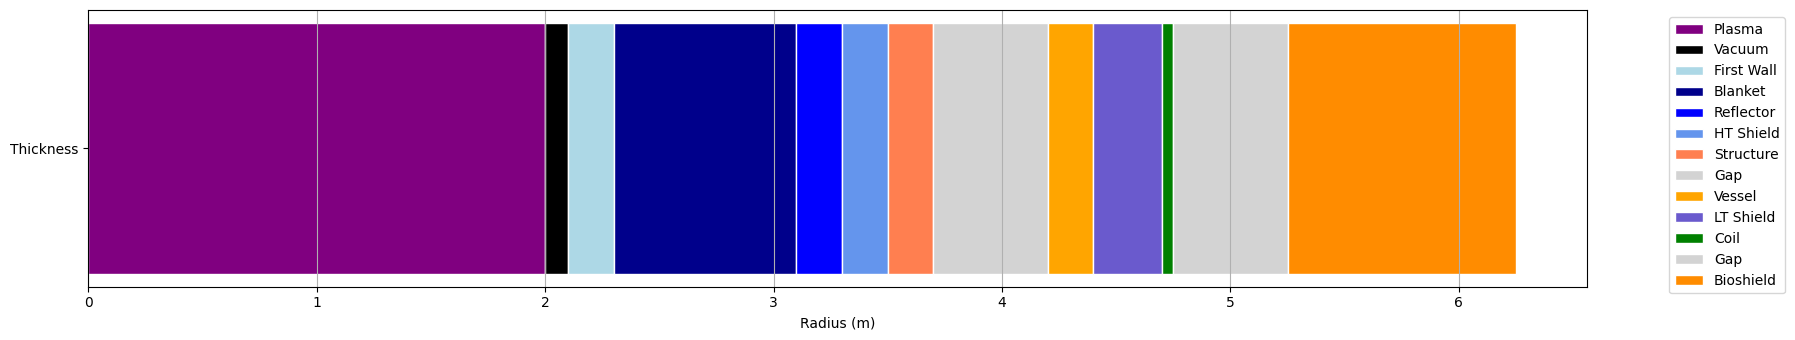

Copied /content/PyFECONS/MIF/Originals/CAS220101_MIF_DT.tex to /content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex.
Replaced 'TH14' with '1' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'RAD14I' with '5.3' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'RAD14O' with '6.3' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'VOL14' with '1083.8' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'TH13' with '0.5' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'RAD13I' with '5.3' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'RAD13O' with '5.3' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'VOL13' with '471.2' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'TH12' with '0.3' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'RAD12I' with '4.7' in '/content/PyFECONS/MIF/Modified/CAS220101_MIF_DT.tex'.
Replaced 'RAD12O' w

In [ ]:
#Cost Category 22.1.1: Reactor Equipment

"""
CALCS
"""

# Radial build inputs
chamber_length=30
axis_t = 0 #[m] distance from r=0 to plasma central axis
plasma_t = 2 #[m] plasma radial thickness
vacuum_t = 0.1 #[m] vacuum radial thickness
firstwall_t = 0.2 #[m] first wall radial thickness
blanket1_t = 0.8 #[m] blanket radial thickness
reflector_t = 0.2 #[m] reflector radial thickness
ht_shield_t = 0.2 #[m] High-temperature shield radial thickness
structure_t = 0.2 #[m] support structure radial thickness
gap1_t = 0.5 #[m] air gap radial thickness
vessel_t = 0.2 #[m] vacuum vessel wall radial thickness
coil_t = 0.05  #[m] TF coil radial thickness
gap2_t = 0.5 #[m] second air gap radial thickness
lt_shield_t = 0.3 #[m] low-temperature shield radial thickness
bioshield_t = 1 #[m] concrete bioshield radial thickness

# Inner radii
axis_ir = axis_t
plasma_ir = axis_ir
vacuum_ir = plasma_t + plasma_ir
firstwall_ir = vacuum_t + vacuum_ir
blanket1_ir = firstwall_ir + firstwall_t
reflector_ir = blanket1_ir + blanket1_t
ht_shield_ir = reflector_ir + reflector_t
structure_ir = ht_shield_ir + ht_shield_t
gap1_ir = structure_ir + structure_t
vessel_ir = gap1_ir + gap1_t
lt_shield_ir = vessel_ir + vessel_t
coil_ir = lt_shield_ir + lt_shield_t
gap2_ir = coil_ir + coil_t
bioshield_ir = gap2_ir + gap2_t

# Outer radii
axis_or = axis_ir + axis_t
plasma_or = plasma_ir + plasma_t
vacuum_or = vacuum_ir + vacuum_t
firstwall_or = firstwall_ir + firstwall_t
blanket1_or = blanket1_ir + blanket1_t
reflector_or = reflector_ir + reflector_t
ht_shield_or = ht_shield_ir + ht_shield_t
structure_or = structure_ir + structure_t
gap1_or = gap1_ir + gap1_t
vessel_or = vessel_ir + vessel_t
lt_shield_or = lt_shield_ir + lt_shield_t
coil_or = coil_ir + coil_t
gap2_or = gap2_ir + gap2_t
bioshield_or = bioshield_ir + bioshield_t

# Volumes for cylinder
def calc_volume(inner, outer):
    return chamber_length * np.pi * (outer**2 - inner**2)

axis_vol = calc_volume(axis_ir, axis_or)
plasma_vol = calc_volume(plasma_ir, plasma_or)
vacuum_vol = calc_volume(vacuum_ir, vacuum_or)
firstwall_vol = calc_volume(firstwall_ir, firstwall_or)
blanket1_vol = calc_volume(blanket1_ir, blanket1_or)
reflector_vol = calc_volume(reflector_ir, reflector_or)
ht_shield_vol = calc_volume(ht_shield_ir, ht_shield_or)
structure_vol = calc_volume(structure_ir, structure_or)
gap1_vol = calc_volume(gap1_ir, gap1_or)
vessel_vol = calc_volume(vessel_ir, vessel_or)
lt_shield_vol = calc_volume(lt_shield_ir, lt_shield_or)
coil_vol = calc_volume(coil_ir, coil_or)*(9*0.779)/40
gap2_vol = calc_volume(gap2_ir, gap2_or)
bioshield_vol = calc_volume(bioshield_ir, bioshield_or)

#First wall
if firstW == "tungsten":
  C22010101 = firstwall_vol*materials["W"]["rho"]*materials["W"]["c_raw"]*materials["W"]["m"]/1e6
elif firstW == "liquid lithium":
  C22010101 = firstwall_vol*materials["Li"]["rho"]*materials["Li"]["c_raw"]*materials["Li"]["m"]/1e6
elif firstW == "beryllium":
  C22010101 = firstwall_vol*materials["Be"]["rho"]*materials["Be"]["c_raw"]*materials["Be"]["m"]/1e6
elif firstW == "FLiBe":
  C22010101 = firstwall_vol*materials["FliBe"]["rho"]*materials["FliBe"]["c_raw"]*materials["FliBe"]["m"]/1e6

#Blanket

if blanketT == "flowing liquid first wall":
  C22010102 = blanket1_vol*materials["Li"]["rho"]*materials["Li"]["c_raw"]*materials["Li"]["m"]/1e6
elif blanketT == "solid first wall with a liquid breeder":
  C22010102 = blanket1_vol*materials["Li"]["rho"]*materials["Li"]["c_raw"]*materials["Li"]["m"]/1e6
elif blanketT == "solid first wall with a solid breeder (Li4SiO4)":
  C22010102 = blanket1_vol*materials["Li4SiO4"]["rho"]*materials["Li4SiO4"]["c_raw"]*materials["Li4SiO4"]["m"]/1e6
elif blanketT == "solid first wall with a solid breeder (Li2TiO3)":
  C22010102 = blanket1_vol*materials["Li2TiO3"]["rho"]*materials["Li2TiO3"]["c_raw"]*materials["Li2TiO3"]["m"]/1e6
elif blanketT == "solid first wall, no breeder (anuetronic fuel)":
  C22010102 = 0


C220101 = C22010101+C22010102 #Total cost of blanket and first wall

"""
PLOTTING RADIAL BUILD
"""

## The names of the sections
# Updated order of the sections
sections = ['Plasma','Vacuum', 'First Wall', 'Blanket', 'Reflector', 'HT Shield', 'Structure', 'Gap', 'Vessel', 'LT Shield', 'Coil', 'Gap', 'Bioshield']

# The thickness of each section (for stacked bar plot)
thickness = [plasma_t,vacuum_t, firstwall_t, blanket1_t, reflector_t, ht_shield_t, structure_t, gap1_t, vessel_t, lt_shield_t, coil_t, gap2_t, bioshield_t]

# Updated colors for each section
colors = ['purple','black', 'lightblue', 'darkblue', 'blue', 'cornflowerblue', 'coral', 'lightgray', 'orange', 'slateblue', 'green', 'lightgray', 'darkorange']

# Plotting the stacked bar graph
fig, ax = plt.subplots(figsize=(18, 3.5)) # Adjust the figsize to get the desired aspect ratio

# Adding each section to the bar plot
left = 0  # Initialize left at 0
for i, (section, thk) in enumerate(zip(sections, thickness)):
    ax.barh('Thickness', thk, left=left, color=colors[i], edgecolor='white', label=section)
    left += thk  # Increment left by the thickness of the current section

# Setting labels and title
ax.set_xlabel('Radius (m)')

# Creating the legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid for the x-axis
ax.xaxis.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Export as pdf
fig.savefig(os.path.join(figures_directory, 'radial_build.pdf'), bbox_inches='tight')


#Template hydration
output_values = {
    'TH14': (bioshield_t, 1), 'RAD14I': (bioshield_ir, 1), 'RAD14O': (bioshield_or, 1), 'VOL14': (bioshield_vol, 1),
    'TH13': (gap2_t, 1), 'RAD13I': (gap2_or, 1), 'RAD13O': (gap2_or, 1), 'VOL13': (gap2_vol, 1),
    'TH12': (lt_shield_t, 1), 'RAD12I': (lt_shield_or, 1), 'RAD12O': (lt_shield_or, 1), 'VOL12': (lt_shield_vol, 1),
    'TH11': (coil_t, 1), 'RAD11I': (coil_ir, 1), 'RAD11O': (coil_or, 1), 'VOL11': (coil_vol, 1),
    'TH10': (lt_shield_t, 1), 'RAD10I': (lt_shield_or, 1), 'RAD10O': (lt_shield_or, 1), 'VOL10': (lt_shield_vol, 1),
    'TH9': (ht_shield_t, 1), 'RAD9I': (ht_shield_or, 1), 'RAD9O': (ht_shield_or, 1), 'VOL9': (ht_shield_vol, 1),
    'TH8': (vessel_t, 1), 'RAD8I': (vessel_or, 1), 'RAD8O': (vessel_or, 1), 'VOL8': (vessel_vol, 1),
    'TH7': (gap1_t, 1), 'RAD7I': (gap1_or, 1), 'RAD7O': (gap1_or, 1), 'VOL7': (gap1_vol, 1),
    'TH6': (reflector_t, 1), 'RAD6I': (reflector_or, 1), 'RAD6O': (reflector_or, 1), 'VOL6': (reflector_vol, 1),
    'TH5': (structure_t, 1), 'RAD5I': (structure_or, 1), 'RAD5O': (structure_or, 1), 'VOL5': (structure_vol, 1),
    'TH4': (blanket1_t, 1), 'RAD4I': (blanket1_or, 1), 'RAD4O': (blanket1_or, 1), 'VOL4': (blanket1_vol, 1),
    'TH3': (firstwall_t, 1), 'RAD3I': (firstwall_or, 1), 'RAD3O': (firstwall_or, 1), 'VOL3': (firstwall_vol, 1),
    'TH2': (vacuum_t, 1), 'RAD2I': (vacuum_or, 1), 'RAD2O': (vacuum_or, 1), 'VOL2': (vacuum_vol, 1),
    'TH1': (plasma_t, 1), 'RAD1I': (plasma_or, 1), 'RAD1O': (plasma_or, 1), 'VOL1': (plasma_vol, 1),
    'primaryC': primaryC, 'secondaryC': secondaryC, 'neutronM': neutronM,
    'structure1': structure1, 'firstW': firstW
}


# Copying the .tex file
copy_file('CAS220101_MIF_DT.tex')
# Overwriting the placeholders in the .tex file
for var_name, var_value in output_values.items():
    if isinstance(var_value, tuple):
        overwrite_variable('CAS220101_MIF_DT.tex', var_name, round(var_value[0], var_value[1]))
    elif var_name in ['primaryC', 'secondaryC', 'neutronM', 'structure1', 'firstW']:
        overwrite_variable('CAS220101_MIF_DT.tex', var_name, var_value)
overwrite_variable('CAS220101_MIF_DT.tex', "C22010101", round_to_2(C22010101))
overwrite_variable('CAS220101_MIF_DT.tex', "C22010102", round_to_2(C22010102))
overwrite_variable('CAS220101_MIF_DT.tex', "C220101", round_to_2(C220101))

In [ ]:
#Cost Category 22.1.2: Shield

"""
CALCS
"""
# Define the fractions
f_SiC = 0.00
FPCPPFbLi = 0.1
f_W = 0.00
f_BFS = 0.9

V_HTS = round(ht_shield_vol,1)

# Calculate the cost for HTS
C_HTS = round(V_HTS * (
    materials["SiC"]["rho"] * materials["SiC"]["c_raw"] * materials["SiC"]["m"] * f_SiC +
    materials["PbLi"]["rho"] * materials["PbLi"]["c"] * FPCPPFbLi +
    materials["W"]["rho"] * materials["W"]["c_raw"] * materials["W"]["m"] * f_W +
    materials["BFS"]["rho"] * materials["BFS"]["c_raw"] * materials["BFS"]["m"] * f_BFS
) / 1e6,1)

# Volume of HTShield that is BFS
V_HTS_BFS = V_HTS * f_BFS
# The cost C_22_1_2 is the same as C_HTS
C22010201 = round(C_HTS,1)*5
C22010202 = lt_shield_vol*materials["SS316"]["c_raw"]*materials["SS316"]["m"]/1e3
C22010203 = bioshield_vol*materials["SS316"]["c_raw"]*materials["SS316"]["m"]/1e3
C22010204 = C22010203*0.1
C220102 = C22010201+C22010202+C22010203+C22010204


copy_file('CAS220102.tex')
overwrite_variable('CAS220102.tex', 'C22010201', round(C22010201))
overwrite_variable('CAS220102.tex', 'C22010202', round(C22010202))
overwrite_variable('CAS220102.tex', 'C22010203', round(C22010203))
overwrite_variable('CAS220102.tex', 'C22010204', round(C22010204))
overwrite_variable('CAS220102.tex', 'C220102', round(C220102))

overwrite_variable('CAS220102.tex', 'V220102', round(V_HTS))
overwrite_variable('CAS220102.tex', 'primaryC', primaryC)
overwrite_variable('CAS220102.tex', 'VOL9', round(ht_shield_vol))
overwrite_variable('CAS220102.tex', 'VOL10', round(lt_shield_vol))
overwrite_variable('CAS220102.tex', 'VOL14', round(bioshield_vol))

Copied /content/PyFECONS/MIF/Originals/CAS220102.tex to /content/PyFECONS/MIF/Modified/CAS220102.tex.
Replaced 'C22010201' with '277' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'C22010202' with '1' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'C22010203' with '4' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'C22010204' with '0' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'C220102' with '283' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'V220102' with '128' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'primaryC' with 'Lead Lithium (PbLi)' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'VOL9' with '128' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'VOL10' with '257' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.
Replaced 'VOL14' with '1084' in '/content/PyFECONS/MIF/Modified/CAS220102.tex'.


In [ ]:
#Cost Category 22.1.3: Coils

# Inputs for the magnets
"""Note that for HTS CICC, the user will be presented with the option of using extrapolation from ,
   in which case the input values for that coil will be overwritten"""

magnetNames=["Solenoid","M1", "M2"] #Enter name of each different type of magnet
magnetCoilCounts = [12,1,2] #Number of each of the above duplicate types

#For magnet type enter: "HTS CICC", "HTS Pancake" , "Copper" for each respective magnet
magnetType = ["Copper","HTS CICC","HTS CICC"] #Coil type for each repsective magnet
#FOR TOKAMAKS: TF, then CS, then PF coils
rCentreList = [5.05, 2.95, 1.5]
zCentreList = [0, 0,0]
dr = [0.9, 0.64, 0.64]
dz = [0.9, 0.64, 0.64]
fracIns = [0.1,0,0] #Total fraction of cross-sectional area comprised of insulation (for copper or tape-tape pancake geometry)
coilTemp = [300,20,20]
mfrFactor =[3,4,4] #Manufacturing factor for each coil
structFactor = 0.25 # Structural multiplication factor. This is multiplied by the magnet material cost (incl mfr factor) and added to the total
######AUTOGEN FOR CICC HTS CABLES ######
autoCICC = ["n","y","y"] #For each magnet, if using HTS CICC, enter "y" to autogen paramters from field and radius, enter "n" to use input lists above
#BELOW ARE ONLY USED IF THE CORRESPONDING MAGNET HAS "y" IN "autoCICC" LIST
autoCICC_r = ["5","2.95","1.5"] #[m] radius of each autogenerated HTS CICC coil
autoCICC_B = ["5","10","10"] #[T] central field of each autogenerated HTS CICC coil

# Constants
tapeW = 0.004  #REBCO tape width in meters
tapeT = 0.00013  # REBCO tape thickness in meters
jTape = 0 # Current density of the tape in A/mm^2, set in magnetsAll function

mCostYBCO = 50 # Material cost of YBCO tape in $/kAm
mCostSS = 5 # Material cost of stainless steel in $/kg
mCostCu = 10.3 # Material cost of copper in $/kg
rebcoDensity = 6350 #Density of REBCO tape in kg/m^3 see https://cds.cern.ch/record/2839592/files/2020_04_21_SHiP_SpectrometerMagnet_Bajas.pdf
cuDensity = 7900  # Density of copper in kg/m^3
ssDensity = 7900  # Density of stainless steel in kg/m^3

#Yuhu CICC HTS cable specifications
cableW = 0.014  # Cable width in meters
cableH = 0.017  # Cable height in meters
fracCsCuYuhu = 0.307  # Fractional cross-sectional area of copper in Yuhu Zhai's cable design
fracCsSsYuhu = 0.257  # Fractional cross-sectional area of stainless steel in Yuhu Zhai's cable design
fracCsScYuhu = 0.257 # Fractional cross-sectional area of REBCO in Yuhu Zhai's cable design
totCsAreaYuhu = 0.000238  # Total cross-sectional area of Yuhu Zhai's cable design in m^2

#HTS pancake constants
mcostI = 20 # Material cost of insulator in $/kg
Idensity = 3000  # Density of insulator in kg/m^3
turnsP = 18 #Turns of REBCO tape per pancake
maxCuCurrent = 20 # [A] max current for water cooled AWG 8 https://www.engineeringtoolbox.com/wire-gauges-d_419.html
cuWireD= 3.3e-3  # copper wire diameter in meters AWG8

"""
HTS CICC AUTO GENERATION OF DESIGN PARAMETERS FROM YUHU ZHAI EXTRAPOLATION
"""

#Extrapolated data from Yuhu Zhai's 2016 cable geometry for HTS CICC auto gen
yuhudata = {
    "R_Turns": [31]*6 + [44]*6 + [54]*6 + [63]*6 + [70]*6 + [77]*6 + [83]*6 + [89]*6 + [94]*6,
    "Z_Turns": [31]*6 + [44]*6 + [54]*6 + [63]*6 + [70]*6 + [77]*6 + [83]*6 + [89]*6 + [94]*6,
    "Single cable I (A)": [6995.627628] * 54,
    "r_av(m)": [2, 4, 6, 8, 10, 12] * 9,
    "z_av(m)": [0] * 54,
    "dr(m)": [0.49]*6 + [0.69]*6 + [0.84]*6 + [0.98]*6 + [1.09]*6 + [1.19]*6 + [1.29]*6 + [1.38]*6 + [1.46]*6,
    "dz(m)": [0.49]*6 + [0.69]*6 + [0.84]*6 + [0.98]*6 + [1.09]*6 + [1.19]*6 + [1.29]*6 + [1.38]*6 + [1.46]*6,
    "B_mag": [2.10616637, 1.055303175, 0.7038001463, 0.5279190692, 0.4223607165, 0.3519787731,
              4.231018337, 2.124598537, 1.417450588, 1.063360003, 0.8507881835,1.067875207,
              6.354170539, 3.198019278, 2.134370652, 1.601384033, 1.281329818, 1.067875207,
              8.619030499, 4.349716057, 2.904216973, 2.179287368, 1.743841805, 1.453386963,
              10.60629681, 5.36649644, 3.584455229, 2.690064162, 2.152680752, 1.794183669,
              12.79002712, 6.48913364, 4.335975808, 3.254475088, 2.604488795, 2.170815472,
              14.80337025, 7.534262639, 5.036490264, 3.780787985, 3.025873763, 2.522119182,
              16.95437589, 8.656634754, 5.789240305, 4.34645187, 3.478801173, 2.899735523,
              18.84016525, 9.649873196, 6.456142837, 4.84777952, 3.880275834, 3.234481465]
}

df_new = pd.DataFrame(yuhudata)
# Extracting necessary columns from data frame for interpolation
interp_data = df_new[['B_mag', 'r_av(m)', 'R_Turns', 'Z_Turns', 'Single cable I (A)', 'dr(m)', 'dz(m)']]

# Preparing the interpolators for each output variable
rTurnsCICC_interp = LinearNDInterpolator(interp_data[['B_mag', 'r_av(m)']].values, interp_data['R_Turns'])
zTurnsCICC_interp = LinearNDInterpolator(interp_data[['B_mag', 'r_av(m)']].values, interp_data['Z_Turns'])
cableCurrentCICC_interp = LinearNDInterpolator(interp_data[['B_mag', 'r_av(m)']].values, interp_data['Single cable I (A)'])
drCICC_interp = LinearNDInterpolator(interp_data[['B_mag', 'r_av(m)']].values, interp_data['dr(m)'])
dzCICC_interp = LinearNDInterpolator(interp_data[['B_mag', 'r_av(m)']].values, interp_data['dz(m)'])
# Function to fit linear regression model for extrapolation
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# Fitting models
X = interp_data[['B_mag', 'r_av(m)']].values
models = {
    'R_Turns': fit_linear_regression(X, interp_data['R_Turns']),
    'Z_Turns': fit_linear_regression(X, interp_data['Z_Turns']),
    'Single cable I (A)': fit_linear_regression(X, interp_data['Single cable I (A)']),
    'dr(m)': fit_linear_regression(X, interp_data['dr(m)']),
    'dz(m)': fit_linear_regression(X, interp_data['dz(m)']),}

# Function to interpolate or extrapolate
def interpolate_or_extrapolate(model_interp, model_regr, X_new, buffer_ratio=0.1, override_checks=False):
    """
    This function attempts to interpolate first, and if the value falls outside of the interpolation range,
    then tries to extrapolate within a dynamically calculated buffer beyond the known data range.
    The range checks can be overridden if necessary.
    """
    # Ensure X_new is two-dimensional
    if X_new.ndim != 2 or X_new.shape[1] != 2:  # Correcting for standard two features input
        raise ValueError("X_new must be a two-dimensional array with shape (n_samples, n_features).")

    # Try to interpolate
    interp_val = model_interp(X_new)
    if not np.isnan(interp_val):  # Check if interpolation was successful
        return interp_val
    else:
        # Dynamically adjust the allowed extrapolation range based on actual data range and a buffer ratio
        extrapolation_ranges = [
            (model_regr.data_range_[i][0] - (model_regr.data_range_[i][1] - model_regr.data_range_[i][0]) * buffer_ratio,
             model_regr.data_range_[i][1] + (model_regr.data_range_[i][1] - model_regr.data_range_[i][0]) * buffer_ratio)
            for i in range(len(model_regr.data_range_))
        ]

        # Check if X_new is within the dynamically adjusted extrapolation range, unless override is active
        if not override_checks:
            for i, (value, (min_val, max_val)) in enumerate(zip(X_new[0], extrapolation_ranges)):
                if not (min_val <= value <= max_val):
                    print(f"Warning: Attempted extrapolation beyond dynamically adjusted range for feature {i}.")
                    return None

        # If within the adjusted range or override is active, perform extrapolation
        return float(model_regr.predict(X_new)[0])  # Ensure predict is called correctly

"""
CRYOGENIC REQUIREMENTS
"""

#COOLING 22.1.3.6
#INPUTS
nobeams = 20 #number of beams supporting each coil, from the coil to the vessel
beamlength = 1.5 #[m] total length of each beam
beamcsarea = 0.25 #[m] cross-sectional area of each support beam
T_mag = 4 #Operating temerature of magnets
T_env = 300 #Temperature of environment (to be cooled from)

#Steel thermal conductivity function
def k_steel(T):
    return 10*T

#Power in from thermal conduction through support
def Qin_struct(no_beams, beam_cs_area, beam_length,k,T_mag):
    return k*beam_cs_area*no_beams/beam_length *(T_env-T_mag)/1e6

#power in from neutron flux, assume 95% is abosrbed in the blanket
def Qin_n(int_coil_area):
    return PNEUTRON*0.05*int_coil_area/(4*np.pi**2*(coil_ir-axis_ir))  #surface area  of torus 4 × π^2 × R × r

#cooling power
C_frac=0.1
def Q_cooling(Qin, C_frac, T_mag, T_env=300):
    try:
        COP = T_mag / (T_env - T_mag) * C_frac  # Assume 10% of Carnot efficiency
    except ZeroDivisionError:
        print("An error occurred: Division by zero. Please enter a value other than 300K for the magnet temperature.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None
    if COP == 0:
        print("Warning: COP is zero. Ensure the magnet temperature is not equal to the environment temperature.")

    return Qin / COP, COP

def Qin_tot(Qin,no_coils):
    return Qin * no_coils

def Q_ohmic(wire_length,cuWireCurrent):
  cures= wire_length*3.2 #Resistance of 3.2 Ohms/1000m see https://www.engineeringtoolbox.com/copper-wire-d_1429.html
  return cuWireCurrent**2*cures/1e6 #MA

#Scaling cooling costs from ITER see Serio, L., ITER Organization and Domestic Agencies and Collaborators, 2010, April. Challenges for cryogenics at ITER. In AIP Conference Proceedings (Vol. 1218, No. 1, pp. 651-662). American Institute of Physics.
#ITER COP
#ITERcooling at 4.2 K
QITER_4K = 47e-3 #47.1 kW at 4.2 K
#Calculating ITER cooling at system operating temp in MW
cost_ITER_cooling = 165.1*1.43 #17.65 M USD in 2009 for 20kW at 4.2 K, adjusted to inflation
lcredit=0.5 #ITER system cooling seems unnecessarily high compared with other costings such as STARFIRE, FIRE
QITER_scaled = QITER_4K / (T_mag / (T_env - 4.2)  * C_frac)  #[MW] ITER cooling power at T_env
ITER_cost_per_MW = cost_ITER_cooling/QITER_scaled*lcredit
Qintot = 0
C22010306 = 0

"""
MAIN MAGNET COSTING
"""
#Main magnet calculation function. Uses above inputs to calculate material requirements for circular geometry, then uses that to determine costs (exception of HTS CICC)
def magnetsAll(cableW, cableH, tapeW, tapeT, mCostYBCO, mCostSS, mCostCu,
               cuDensity, ssDensity, fracCsCuYuhu, fracCsSsYuhu, dr,dz,
               rCentre, zCentre, noCoils, mfrFactor, magnetType,fracIns,
               autoCICC,autoCICC_r, autoCICC_B,coilTemp):
    jTape = 150 #[A] approximate critical current density of YBCO at 18T https://www.sciencedirect.com/science/article/pii/S0011227516303812
    Qintot = 0
    if magnetType == "HTS CICC":

      if autoCICC == "y":

        # Interpolated values
        X_new = np.array([[2, 4]])  # Adjusted for your new data
        override_checks = True  # Set this to True to bypass the range checks
        rTurns = interpolate_or_extrapolate(rTurnsCICC_interp, models['R_Turns'], X_new, override_checks=override_checks)
        zTurns = interpolate_or_extrapolate(zTurnsCICC_interp, models['Z_Turns'], X_new, override_checks=override_checks)
        cableCurrent = interpolate_or_extrapolate(cableCurrentCICC_interp, models['Single cable I (A)'], X_new, override_checks=override_checks)
        dr = interpolate_or_extrapolate(drCICC_interp, models['dr(m)'], X_new, override_checks=override_checks)
        dz = interpolate_or_extrapolate(dzCICC_interp, models['dz(m)'], X_new, override_checks=override_checks)

        turnsScTot = rTurns*zTurns

        csArea = dr*dz
        turnsC = csArea / (cableW * cableH)
        turnsScS = turnsScTot/turnsC #Turns of REBCO in each cable
        currentSupply = turnsC*cableCurrent

        volCoil = csArea*2*np.pi*rCentre
        tapeLength = turnsScTot * rCentre * 2 * math.pi / 1e3
        maxTapeCurrent = cableCurrent/turnsScS


        costSC = maxTapeCurrent / 1e3 * tapeLength * 1e3 * mCostYBCO / 1e6
        costCu = fracCsCuYuhu * mCostCu * volCoil * cuDensity / 1e6
        costSS = fracCsSsYuhu * mCostSS * volCoil * ssDensity / 1e6
        costI = np.nan
        totMatCost = costSC + costCu + costSS
        magCost = totMatCost * mfrFactor
        coilMass = (rebcoDensity*tapeLength*tapeW*tapeT) + (fracCsCuYuhu * volCoil * cuDensity) + (fracCsSsYuhu * volCoil * ssDensity) #mass of the coil in kg

        Qinn = Qin_n(dz*abs((rCentre-dr/2))) #Neutron heat loading for one coil
        #For 1 coil, assume 20 support beams, 5m length, 0.5m^2 cs area, target temp of 20K, env temp of 300 K
        Qinstruct = Qin_struct(nobeams, beamcsarea, beamlength,k_steel((T_env+coilTemp)/2),(T_env+coilTemp)/2)
        Qin = (Qinstruct+ Qinn)#total input heat for one coil
        coolingCost = Qin*ITER_cost_per_MW

      elif autoCICC == "n":

        maxTapeCurrent = jTape * tapeW *1e3 *tapeT *1e3 # Current in A
        turnsScS = (cableW * cableH*fracCsScYuhu) / (tapeW * tapeT) #turns of REBCO in one cable
        cableCurrent = maxTapeCurrent * turnsScS #Current per cable

        csArea = dr*dz #cross sectional area of entire coil
        turnsC = csArea / (cableW * cableH) #turns of cable in the coil
        currentSupply = cableCurrent * turnsC #total current supply to the coil
        volCoil = csArea*2*np.pi*rCentre #volume of the coil

        turnsScTot = turnsScS * turnsC #total turns of REBCO
        tapeLength = turnsScTot * rCentre * 2 * np.pi / 1e3 #total length of REBCO in km

        costSC = maxTapeCurrent / 1e3 * tapeLength * 1e3 * mCostYBCO / 1e6 #total cost of REBCO
        costCu = fracCsCuYuhu * mCostCu * volCoil * cuDensity / 1e6 #total cost of copper
        costSS = fracCsSsYuhu * mCostSS * volCoil * ssDensity / 1e6 #total cost of stainless steel
        costI = np.nan #total cost of insulation
        totMatCost = costSC + costCu + costSS
        magCost = totMatCost * mfrFactor
        coilMass = (rebcoDensity*tapeLength*tapeW*tapeT) + (fracCsCuYuhu * volCoil * cuDensity) + (fracCsSsYuhu * volCoil * ssDensity)

        Qinn = Qin_n(dz*(rCentre-dr/2)) #Neutron heat loading for one coil
        #For 1 coil, assume 20 support beams, 5m length, 0.5m^2 cs area, target temp of 20K, env temp of 300 K
        Qinstruct = Qin_struct(nobeams, beamcsarea, beamlength,k_steel((T_env+coilTemp)/2),(T_env+coilTemp)/2)
        Qin = (Qinstruct+ Qinn) #total input heat for one coil
        coolingCost = Qin*ITER_cost_per_MW

    elif magnetType == "HTS Pancake":

      jTape = 150 #critical current density of YBCO at 18T

      cableW = np.nan  # Cables are not used here
      cableH = np.nan  # Cables are not used here

      maxTapeCurrent = jTape * tapeW *1e3 *tapeT *1e3 # Current in A
      csArea = dr*dz
      turnsScS =  (1-fracIns)*csArea / (tapeW * tapeT)
      cableCurrent = maxTapeCurrent * turnsScS #In this case the 'cable' is the entire winding
      volCoil = csArea*2*np.pi*rCentre
      turnsC = np.nan
      turnsScTot = turnsScS
      currentSupply = cableCurrent

      turnsI = fracIns*csArea / (tapeW * tapeT) #turns of (partial?) insulation
      noP = turnsScS/turnsP #number of pancakes based on total required turns and the number of turns in a reference pancake coil

      volI = turnsScS * rCentre * 2 * np.pi/1e3*fracIns*(tapeW * tapeT) #total volume of insulation [m^3]
      tapeLength = turnsScS * rCentre * 2 * np.pi / 1e3

      costSC = maxTapeCurrent / 1e3 * tapeLength * 1e3 * mCostYBCO / 1e6
      costI = mcostI * volI * Idensity/1e6  # material cost of inter-tape insulation [m$]
      costCu = 0
      costSS = 0
      totMatCost = costSC + costCu + costSS + costI
      magCost = totMatCost * mfrFactor
      coilMass = (rebcoDensity*tapeLength*tapeW*tapeT) + (volI * Idensity)

      Qinn = Qin_n(dz*(rCentre-dr/2)) #Neutron heat loading for one coil
      #For 1 coil, assume 20 support beams, 5m length, 0.5m^2 cs area, target temp of 20K, env temp of 300 K
      Qinstruct = Qin_struct(nobeams, beamcsarea, beamlength,k_steel((T_env+coilTemp)/2),(T_env+coilTemp)/2)

      Qin = (Qinstruct+ Qinn) #total input heat for one coil
      coolingCost = Qin*ITER_cost_per_MW
      print("coolingCost pancake:",coolingCost)

    elif magnetType == "Copper":

      jTape = maxCuCurrent/(0.5*cuWireD*1e3)**2

      cableW = np.nan  # Cables are not used here
      cableH = np.nan  # Cables are not used here

      #In this case 'Tape' refers to copper wire AWG 11
      csArea = dr*dz

      turnsScS = (1-fracIns)*csArea / (0.5*cuWireD)**2
      turnsI = fracIns*csArea / (0.5*cuWireD)**2 #turns of (partial?) insulation

      volCoil = csArea*2*np.pi*rCentre
      cuWireCurrent = maxTapeCurrent = maxCuCurrent #current through each cu_wire [A]
      turnsScTot=  turnsScS
      turnsC = np.nan
      cableCurrent = np.nan
      tapeLength = turnsScS * rCentre * 2 * np.pi / 1e3
      currentSupply = cuWireCurrent*turnsScS #Total supply current [A]

      volI = fracIns*csArea*rCentre*2*np.pi #total volume of insulation [m^3]

      costSC = 0
      costCu = (volCoil - volI)*cuDensity*mCostCu/1e6 #[$] simple volumetric material calc
      costI = mcostI * volI * Idensity/1e6  # material cost of inter-turn insulation [m$]
      costSS = 0
      totMatCost = costSC + costCu + costSS +costI
      magCost = totMatCost * mfrFactor
      coilMass = ((volCoil - volI)*cuDensity) + (volI * Idensity)

      Qinn = Qin_n(dz*(rCentre-dr/2))
      Qinstruct = Qin_struct(nobeams, beamcsarea, beamlength, k_steel((T_env + coilTemp) / 2), (T_env + coilTemp) / 2)
      Qohmic = Q_ohmic(tapeLength, cuWireCurrent)
      Qin = (Qinstruct + Qinn + Qohmic)
      coolingCost = Qin*ITER_cost_per_MW

    return {
        'volCoil': volCoil,
        'csArea': csArea,
        'turnsC': turnsC,
        'cableCurrent': cableCurrent,
        'currentSupply': currentSupply*1e-6,
        'turnsScTot': turnsScTot,
        'tapeLength': tapeLength,
        'tapeCurrent': maxTapeCurrent,
        'costSC': costSC,
        'costCu': costCu,
        'costSS': costSS,
        'costI':costI,
        'totMatCost': totMatCost,
        'magCost': magCost,
        'dr':dr,
        'dz':dz,
        'magnetType':magnetType,
        'fracIns':fracIns,
        'mfrFactor':mfrFactor,
        'jTape':jTape,
        'cableW':cableW,
        'cableH':cableH,
        'coilMass':coilMass,
        'Qin': Qin,
        'coolingCost':coolingCost
  }


# Initialize lists and dictionaries
magnetCosts = []
magnetStructCosts = []
allMagnetProperties = {}
variablesToOverwrite = {}
suffix_variables = {}

# Calculate magnet properties and costs for each magnet once per iteration
for i, magnetName in enumerate(magnetNames):
    # Call the magnetsAll function once per magnet
    magnetProperties = magnetsAll(cableW, cableH, tapeW, tapeT, mCostYBCO, mCostSS, mCostCu,
                                  cuDensity, ssDensity, fracCsCuYuhu, fracCsSsYuhu, dr[i], dz[i],
                                  rCentreList[i], zCentreList[i], magnetCoilCounts[i], mfrFactor[i],
                                  magnetType[i], fracIns[i], autoCICC[i],autoCICC_r[i], autoCICC_B[i],coilTemp[i])

    # Update dictionaries and lists with the results
    allMagnetProperties.update({f'magnet{i+1}{k}': v for k, v in magnetProperties.items()})
    magnetCosts.append(magnetProperties['magCost'])
    magnetStructCosts.append((structFactor * magnetProperties['magCost'])+magnetProperties['coolingCost'])

    Qintot += magnetProperties.get('Qin', 0)
    C22010306 += magnetProperties.get('coolingCost', 0)


    # Update variables for later use in .tex file
    variablesToOverwrite[f'no{magnetName}Coils'] = magnetCoilCounts[i]
    variablesToOverwrite[f'{magnetName}StructCost'] = structFactor * magnetProperties['magCost']
    variablesToOverwrite[f'{magnetName}MagCost'] = magnetProperties['magCost']
    magnetTotalCost = magnetProperties['magCost'] + variablesToOverwrite[f'{magnetName}StructCost']
    magnetTotalCostsIndividual = magnetTotalCost
    variablesToOverwrite[f'total{magnetName}CostI'] = magnetTotalCost
    variablesToOverwrite[f'total{magnetName}Cost'] = magnetTotalCost * magnetCoilCounts[i]


    # Accumulate suffix variables for sorting
    for key, value in magnetProperties.items():
        suffix_variables[f"{key}{i+1}"] = value

# Additional totals and calculations
totStructCost = sum(magnetStructCosts)
totnocoils = sum(magnetCoilCounts)
nopfcoils = sum(magnetCoilCounts[2:])
nopfpairs = nopfcoils / 2
magnetTotalCosts = [totalCost * coilCount for totalCost, coilCount in zip(magnetCosts, magnetCoilCounts)]

# Assign calculated totals to variables for .tex file
C22010301 = float(magnetTotalCosts[0])  # TF coils
C22010302 = float(magnetTotalCosts[1])  # CS coils
C22010303 = float(sum(magnetTotalCosts[2:]))  # PF coils
C22010304 = 0.05 * (C22010301 + C22010302 + C22010303)  # Shim coil costs, taken as 5% total primary magnet costs
C22010305 = float(totStructCost)  # Structural cost
C220103 = C22010301 + C22010302 + C22010303 + C22010304 + C22010305  + float(C22010306[0]) # Total cost

"""
REMAINDER OF COOLING CALCULATIONS AND PLOTTING
"""
"""#Cooling power requirements for various temperature differences
fig, ax = plt.subplots(figsize=(10, 6))
# Plotting on the axes
ax.plot(T_mag_range, cooling_power_requirements)
ax.set_xlabel('Target Temperature (K)')
ax.set_ylabel('Cooling Power Requirement (MW)')
# ax.set_title('Cooling Power Requirement vs. Target Temperature')
ax.grid(True)
plt.show()
# Export as PDF
fig.savefig(os.path.join(figures_directory, 'cooling_efficiency.pdf'), bbox_inches='tight')
"""

"""
Overwriting
"""

# Update variablesToOverwrite dictionary with new totals
variablesToOverwrite.update({
    'structFactor': structFactor, 'mcostI': mCostYBCO, 'nopfcoils': nopfcoils, 'nopfpairs': nopfpairs, 'mCostYBCO': mCostYBCO,
    'C22010301': C22010301, 'C22010302': C22010302, 'C22010303': C22010303,
    'C22010304': C22010304, 'C22010305': C22010305, 'C22010306': C22010306, 'C220103': C220103
})

# Sort variables with numerical suffixes in descending order for .tex file
sorted_suffix_variables = dict(sorted(suffix_variables.items(), key=lambda item: int(re.search(r'\d+$', item[0]).group()), reverse=True))

# Combine the sorted variables back into the main dictionary
variablesToOverwrite.update(sorted_suffix_variables)

# Overwrite each variable in the .tex file
copy_file('CAS220103_MIF_DT_mirror.tex')
for varName, varValue in variablesToOverwrite.items():
    # Check if varValue is a string
    if isinstance(varValue, str):
        # Directly use the string without conversion
        overwrite_variable('CAS220103_MIF_DT_mirror.tex', varName, varValue)
    else:
        # Assuming non-string values can be converted to float and rounded
        overwrite_variable('CAS220103_MIF_DT_mirror.tex', varName, round_to_2(float(varValue)))




def generateVariableNames(listName, listValues):
    return {f"{listName}{i+1}": value for i, value in enumerate(listValues)}

def updateLatexValues(*lists):
    for listName, listValues in lists:
        varsToUpdate = generateVariableNames(listName, listValues)
        for varName, varValue in varsToUpdate.items():
            overwrite_variable('CAS220103_MIF_DT_mirror.tex', varName, float(varValue))

# Updating the LaTeX document with new values
updateLatexValues(
    ("rCentre", rCentreList),
    ("zCentre", zCentreList) )


overwrite_variable('CAS220103_MIF_DT_mirror.tex', 'C22010301', round(C22010301))
overwrite_variable('CAS220103_MIF_DT_mirror.tex', 'C22010302', round(C22010302))
overwrite_variable('CAS220103_MIF_DT_mirror.tex', 'C22010303', round(C22010303))
overwrite_variable('CAS220103_MIF_DT_mirror.tex', 'C22010304', round(C22010304))
overwrite_variable('CAS220103_MIF_DT_mirror.tex', 'C22010305', round(C22010305))
overwrite_variable('CAS220103_MIF_DT_mirror.tex', 'C22010306', round(C22010306[0]))
overwrite_variable('CAS220103_MIF_DT_mirror.tex', 'C220103', round(C220103))


Copied /content/PyFECONS/MIF/Originals/CAS220103_MIF_DT_mirror.tex to /content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex.
Replaced 'noSolenoidCoils' with '12.0' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'SolenoidStructCost' with '1.5' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'SolenoidMagCost' with '6.1' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'totalSolenoidCostI' with '7.6' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'totalSolenoidCost' with '92.0' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'noM1Coils' with '1.0' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'M1StructCost' with '12.0' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'M1MagCost' with '50.0' in '/content/PyFECONS/MIF/Modified/CAS220103_MIF_DT_mirror.tex'.
Replaced 'totalM1CostI' with '62.0' in '/content/

<ipython-input-18-d1fdcf05387f>:423: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C22010302 = float(magnetTotalCosts[1])  # CS coils
<ipython-input-18-d1fdcf05387f>:424: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C22010303 = float(sum(magnetTotalCosts[2:]))  # PF coils
<ipython-input-18-d1fdcf05387f>:426: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C22010305 = float(totStructCost)  # Structural cost
<ipython-input-18-d1fdcf05387f>:471: DeprecationWarning: Con

In [ ]:
#22.1.4 Supplementary heating

#see pg 90 https://cer.ucsd.edu/_files/publications/UCSD-CER-13-01.pdf
heating_refs = {
    "ARIES-AT": {"Type": "ICRF/LH", "Power (MW)": 37.441, "$/W (2009)": 1.67, "$/W (2023)": 2.3881},
    "ARIES-I": {"Type": "ICRF/LH", "Power (MW)": 96.707, "$/W (2009)": 1.87, "$/W (2023)": 2.6741},
    "ARIES-I'": {"Type": "ICRF/LH", "Power (MW)": 202.5, "$/W (2009)": 1.96, "$/W (2023)": 2.8028},
    "ARIES-RS": {"Type": "ICRF/LH/HFFW", "Power (MW)": 80.773, "$/W (2009)": 3.09, "$/W (2023)": 4.4187},
    "ARIES-IV": {"Type": "ICRF/LH", "Power (MW)": 68, "$/W (2009)": 4.35, "$/W (2023)": 6.2205},
    "ARIES-II": {"Type": "ICRF/LH", "Power (MW)": 66.1, "$/W (2009)": 4.47, "$/W (2023)": 6.3921},
    "ARIES-III'": {"Type": "NBI", "Power (MW)": 163.2, "$/W (2009)": 4.93, "$/W (2023)": 7.0499},
    "ARIES-III": {"Type": "NBI", "Power (MW)": 172, "$/W (2009)": 4.95, "$/W (2023)": 7.0785},
    "ITER": {"Type": "ICRF", "Power (MW)": 5.5, "$/W (2009)": None, "$/W (2023)": 7.865},
    "Average": {"Type": None, "Power (MW)": 110.840125, "$/W (2009)": 3.643333333, "$/W (2023)": 5.209966667},
    "Average (ICRF)": {"Type": None, "Power (MW)": 91.92016667, "$/W (2009)": 2.901666667, "$/W (2023)": 4.149383333},
    "Average (NBI)": {"Type": None, "Power (MW)": 167.6, "$/W (2009)": 4.94, "$/W (2023)": 7.0642},
}

NBIpower = 50 #MW
C22010401= heating_refs["Average (NBI)"]["$/W (2023)"]*NBIpower

ICRFpower = 0#MW
C22010402= heating_refs["Average (ICRF)"]["$/W (2023)"]*ICRFpower

C220104 = C22010401+C22010402
copy_file('CAS220104_MIF_DT.tex')
overwrite_variable('CAS220104_MIF_DT.tex', 'C22010401', round(C22010401))
overwrite_variable('CAS220104_MIF_DT.tex', 'C22010402', round(C22010402))
overwrite_variable('CAS220104_MIF_DT.tex', 'C220104', round(C220104))
overwrite_variable('CAS220104_MIF_DT.tex', 'NBIPOWER', round(NBIpower,3))
overwrite_variable('CAS220104_MIF_DT.tex', 'ICRFPOWER', round(ICRFpower,3))

Copied /content/PyFECONS/MIF/Originals/CAS220104_MIF_DT.tex to /content/PyFECONS/MIF/Modified/CAS220104_MIF_DT.tex.
Replaced 'C22010401' with '353' in '/content/PyFECONS/MIF/Modified/CAS220104_MIF_DT.tex'.
Replaced 'C22010402' with '0' in '/content/PyFECONS/MIF/Modified/CAS220104_MIF_DT.tex'.
Replaced 'C220104' with '353' in '/content/PyFECONS/MIF/Modified/CAS220104_MIF_DT.tex'.
Replaced 'NBIPOWER' with '50' in '/content/PyFECONS/MIF/Modified/CAS220104_MIF_DT.tex'.
Replaced 'ICRFPOWER' with '0' in '/content/PyFECONS/MIF/Modified/CAS220104_MIF_DT.tex'.


In [ ]:
#22.1.5 primary structure
#INPUT - choose from pga of 0.1, 0.2, 0.3 or 0.5. PGA stands for peak ground acceleration and increasing values would correlate to an increased risk region.
systpga=0.1

#Dictionary of fission reactor costs from "Towards standardized nuclear reactors: Seismic isolation and the cost impact of the earthquake load case"
primary_struct_costs = {
    "analyzecosts":30,
    "unit1seiscosts":25,
    "regrevcosts":30,
    "unit1fabcosts":100,
    "unit10fabcosts":70,
    "pga01engcosts":115,
    "pga01fabcosts":115,
    "pga02engcosts":125,
    "pga02fabcosts":130,
    "pga03engcosts":140,
    "pga03fabcosts":165,
    "pga05engcosts":160,
    "pga05fabcosts":235,
}

#learning credit multiplication factor
learning_credit=0.5
#scaling to system power and learnign credit
scaled_primary_struct_costs = {key: value * PET/1000*learning_credit for key, value in primary_struct_costs.items()}

#standard engineering costs
C22010501= scaled_primary_struct_costs["analyzecosts"]+scaled_primary_struct_costs["unit1seiscosts"] + scaled_primary_struct_costs["regrevcosts"]
#standard fabrication costs
C22010502= scaled_primary_struct_costs["unit1fabcosts"]+scaled_primary_struct_costs["unit10fabcosts"]

copy_file('CAS220105.tex')
#Calculate and overwrite costs based on the input pga for the system
if systpga==0.1:
  #pga 0.1 engineering costs
  C22010501 += scaled_primary_struct_costs["pga01engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga01engcosts"]))
  #pga 0.1 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga01fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga01fabcosts"]))
elif systpga==0.2:
  #pga 0.2 engineering costs
  C22010501 += scaled_primary_struct_costs["pga02engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga02engcosts"]))
  #pga 0.2 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga02fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga02fabcosts"]))

elif systpga==0.3:
  #pga 0.3 engineering costs
  C22010501 += scaled_primary_struct_costs["pga03engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga03engcosts"]))
  #pga 0.3 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga03fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga03fabcosts"]))
elif systpga==0.5:
  #pga 0.5 engineering costs
  C22010501 += scaled_primary_struct_costs["pga05engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga05engcosts"]))
  #pga 0.5 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga05fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga05fabcosts"]))

#total cost calculation
C220105 = C22010501+C22010502


#overwriting dictionary items
for var_name, var_value in scaled_primary_struct_costs.items():
    overwrite_variable('CAS220105.tex', var_name, round(var_value,2))

overwrite_variable('CAS220105.tex', 'C22010501', round(C22010501))
overwrite_variable('CAS220105.tex', 'C22010502', round(C22010502))
overwrite_variable('CAS220105.tex', 'C220105', round(C220105))
overwrite_variable('CAS220105.tex', 'systPGA', round(systpga))
overwrite_variable('CAS220105.tex', 'PNRL', round(PNRL))

Copied /content/PyFECONS/MIF/Originals/CAS220105.tex to /content/PyFECONS/MIF/Modified/CAS220105.tex.
Replaced 'pgaengcosts' with '95' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'pgafabcosts' with '95' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'analyzecosts' with '24.68' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'unit1seiscosts' with '20.57' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'regrevcosts' with '24.68' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'unit1fabcosts' with '82.27' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'unit10fabcosts' with '57.59' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'pga01engcosts' with '94.62' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'pga01fabcosts' with '94.62' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'pga02engcosts' with '102.84' in '/content/PyFECONS/MIF/Modified/CAS220105.tex'.
Replaced 'pga02fab

In [ ]:
##22.1.6 Vacuum system
#22.1.6.1 Vacuum Vessel

# Parameters
middle_length = chamber_length  # Middle part length in meters
middle_diameter = 2*vessel_ir  # Middle part diameter in meters
end_length = 8  # End parts length in meters (each)
end_diameter = 3*vessel_ir  # End parts diameter in meters
fillet_radius = 0.022 * middle_length  # Fillet radius in meters, adjust as necessary
thickness = 0.02  # Thickness in meters

# Calculate the outer volumes
middle_volume_outer = math.pi * (middle_diameter / 2) ** 2 * middle_length
end_volume_outer = math.pi * (end_diameter / 2) ** 2 * end_length

# Calculate the inner volumes
middle_volume_inner = math.pi * (middle_diameter / 2 - thickness) ** 2 * middle_length
end_volume_inner = math.pi * (end_diameter / 2 - thickness) ** 2 * end_length

# Total outer and inner volumes
total_volume_outer = middle_volume_outer + 2 * end_volume_outer
total_volume_inner = middle_volume_inner + 2 * end_volume_inner
vesvol = total_volume_inner

# Material volume
materialvolume = total_volume_outer - total_volume_inner

# Material properties (density and cost)
ss_density = 6700  # kg/m^3
ss_cost = 5  # $/kg

# Calculate mass and cost
vesmfr = 10
massstruct = materialvolume * ss_density
vesmatcost = ss_cost * massstruct
C22010601 = vesmatcost*vesmfr/1e6

#COOLING 22.1.6.2
C22010602= 0

#VACUUM PUMPING 22.1.6.3
#assume 1 second vac rate
#cost of 1 vacuum pump, scaled from 1985 dollars
cost_pump = 40000
#48 pumps needed for 200^3 system
vpump_cap = 200/48 #m^3 capable of beign pumped by 1 pump
no_vpumps = int(vesvol/vpump_cap)#Number of vacuum pumps required to pump the full vacuum in 1 second
C22010603  = no_vpumps*cost_pump/1e6

#ROUGHING PUMP 22.1.6.4
#from STARFIRE, only 1 needed
C22010604 = 120000*2.85/1e6


C220106 = C22010601  +C22010602 +C22010603+C22010604
copy_file('CAS220106_MIF.tex')
overwrite_variable('CAS220106_MIF.tex', 'C22010601', round(C22010601))
overwrite_variable('CAS220106_MIF.tex', 'C22010602', round(C22010601))
overwrite_variable('CAS220106_MIF.tex', 'C22010603', round(C22010603))
overwrite_variable('CAS220106_MIF.tex', 'C22010604', round(C22010604))
overwrite_variable('CAS220106_MIF.tex', 'C220106', round(C220106))
overwrite_variable('CAS220106_MIF.tex', 'vesvol', round(vesvol))
overwrite_variable('CAS220106_MIF.tex', 'materialvolume', round(materialvolume))
overwrite_variable('CAS220106_MIF.tex', 'massstruct', round(massstruct))
overwrite_variable('CAS220106_MIF.tex', 'vesmatcost', round(vesmatcost/1e6,1))
overwrite_variable('CAS220106_MIF.tex', 'vesmfr', round(vesmfr))

Copied /content/PyFECONS/MIF/Originals/CAS220106_MIF.tex to /content/PyFECONS/MIF/Modified/CAS220106_MIF.tex.
Replaced 'C22010601' with '6' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'C22010602' with '0' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'C22010603' with '3' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'C22010604' with '0.34' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'C220106' with '9' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'vesvol' with '266' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'materialvolume' with '37' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'massstruct' with '289' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'vesmatcost' with '0.6' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.
Replaced 'vesmfr' with '10' in '/content/PyFECONS/MIF/Modified/CAS220106_MIF.tex'.


In [ ]:
#Cost Category 22.1.7 Power supplies


#Scaled relative to ITER for a 500MW fusion power system
C220107 = 0.5 * 269 * PET/500

# INPUTS
captm = 60  # max temp rating of the film capacitor
capta = 20  # ambient temperature of the application
capdelt = 30  # temperature rise due to ripple current
capvr = 20000  # rated voltage of capacitor
capx = (captm - capta - capdelt) / 10
capl1 = 50000  # load life rating of the film capacitor

# Arrays for storing calculated values
capv0 = np.zeros(100)
capl2 = np.zeros(100)
capcostfac = np.zeros(100)

# Loop for calculations
for i in range(100):
    capv0[i] = capvr / 100 * (i + 1)  # applied voltage in application
    capl2[i] = capl1 * (capvr / capv0[i]) ** 7 * 2 ** capx
    capcostfac[i] = 1 / (capv0[i] / capvr) ** 2

# Convert applied voltage from V to kV for plotting
capv0_kV = capv0 / 1000  # Convert to kV

# Re-plotting the third chart according to new specifications: not using standard form for y-axis and plotting in blue
plt.figure(figsize=[15, 5])

# Lifetime extension factor plot (unchanged)
plt.subplot(1, 3, 1)
plt.semilogy(capv0 / capvr, capl2 / capl1,'b')
plt.title('Lifetime Extension Factor')
plt.xlabel('Ratio of applied to rated voltage')
plt.ylabel('Lifetime extension factor, L2/L1')
plt.axis([0, 1, 1, 100000])

# Lifetime of bank in years plot (unchanged)
plt.subplot(1, 3, 2)
plt.semilogy(capv0 / capvr, capl2 / (86000 * 365), 'b')  # Assuming 86000 cycles per year
plt.title('Lifetime of Bank in Years')
plt.xlabel('Ratio of applied to rated voltage')
plt.ylabel('Lifetime of bank in years, at 1Hz')
plt.axis([0, 1, 0.001, 100])

# Bank cost factor plot with specified changes
plt.subplot(1, 3, 3)
plt.plot(capv0 / capvr, capcostfac, 'b')  # Changed to blue color
plt.title('Bank Cost Factor')
plt.xlabel('Ratio of applied to rated voltage')
plt.ylabel('Bank cost factor')
plt.yscale('linear')  # Changed to linear scale
plt.axis([0, 1, 1, 100])

# Show updated plots
plt.tight_layout()
plt.show()

fig.savefig(os.path.join(figures_directory, 'cap_derate.pdf'), bbox_inches='tight')




copy_file('CAS220107_MIF.tex')
overwrite_variable('CAS220107_MIF.tex', 'C220107', round(C220107))
overwrite_variable('CAS220107_MIF.tex', 'PNRL', round(PNRL))

Copied /content/PyFECONS/MIF/Originals/CAS220107_MIF.tex to /content/PyFECONS/MIF/Modified/CAS220107_MIF.tex.
Replaced 'C220107' with '1402' in '/content/PyFECONS/MIF/Modified/CAS220107_MIF.tex'.
Replaced 'PNRL' with '2600' in '/content/PyFECONS/MIF/Modified/CAS220107_MIF.tex'.


In [ ]:
#22.1.8 Divertor or target factory

C220108 = 0
#UNCOMMENT FOLLOWING SECTION IF CONCEPT HAS DIVERTOR
"""
#22.1.8 Divertor
#Simple volumetric calculation based on reactor geometry, user input, and tungsten material properties (see "materials" dictionary)
divertorMajRad = rCentreList[0]
divertorMinRad = firstwall_ir-axis_ir
divertorThicknessZ=0.2 #[m]
divertorThicknessR= divertorMinRad*2#[m]
divertorMaterial = materials["W"] #Tungsten
divertorVol = ((divertorMajRad+divertorThicknessR)**2-(divertorMajRad-divertorThicknessR)**2)*np.pi*divertorThicknessZ #volume of the divertor based on TF coil radius
divertorMass= divertorVol*divertorMaterial["rho"]
divertorMatCost=divertorMass*divertorMaterial["c_raw"]
divertorCost=divertorMatCost*divertorMaterial["m"]
C220108 = divertorCost/1e6

copy_file('CAS220108_MFE.tex')
overwrite_variable('CAS220108_MFE.tex', 'C220108', round(C220108))
overwrite_variable('CAS220108_MFE.tex', 'divertorMajRad', round(divertorMajRad))
overwrite_variable('CAS220108_MFE.tex', 'divertorMinRad', round(divertorMinRad))
overwrite_variable('CAS220108_MFE.tex', 'divertorThicknessZ', round(divertorThicknessZ))
overwrite_variable('CAS220108_MFE.tex', 'divertorMaterial', "Tungsten")
overwrite_variable('CAS220108_MFE.tex', 'divertorVol', round(divertorVol))
overwrite_variable('CAS220108_MFE.tex', 'divertorMass', round(divertorMass))
"""

#22.1.8 Target factory

#INPUT
freq=1 #[Hz]

LIFE_target_yield = 132 #MJ released per target from https://www.sciencedirect.com/science/article/abs/pii/S0920379613007357
syst_PRF = PNRL/LIFE_target_yield #required PRF to acheive target PNRL (assuming exact target design as specified)
learning_credit = 0.8 #learning credit multiplication factor

yearlytcost_PFR_coords = [
    [4.948453608247423, 39.160839160839174],
    [6.892488954344623, 50.349650349650375],
    [9.013254786450663, 61.53846153846155],
    [11.045655375552284, 73.28671328671331],
    [12.989690721649483, 83.91608391608395],
    [15.022091310751103, 94.54545454545456],
    [16.966126656848303, 105.73426573426576],
    [18.954344624447714, 118.04195804195807],
    [20.898379970544916, 129.79020979020981],
    [22.930780559646536, 139.30069930069934],
    [24.963181148748156, 151.04895104895107]
]

pertarget_PFR_coords = [
    [4.9327354260089695, 0.25636363636363635],
    [6.95067264573991, 0.23454545454545453],
    [8.968609865470853, 0.21818181818181814],
    [10.986547085201797, 0.21363636363636362],
    [13.004484304932737, 0.20590909090909087],
    [14.977578475336328, 0.20181818181818179],
    [16.99551569506727, 0.19909090909090907],
    [18.968609865470853, 0.19545454545454544],
    [21.031390134529147, 0.19499999999999998],
    [23.00448430493274, 0.1927272727272727],
    [24.97757847533633, 0.19136363636363635]
]

def interpolate_and_plot(coordinates1, coordinates2):
    # Function to interpolate and plot a single set of coordinates
    def interpolate_plot(ax, coordinates, title, ylabel):
        x = [coord[0] for coord in coordinates]
        y = [coord[1] for coord in coordinates]

        # Creating an interpolation function
        interpolation_function = interp1d(x, y, kind='linear', fill_value="extrapolate")

        # Generating new x values for interpolation and extrapolation
        x_new = np.linspace(0.5, max(x), num=500, endpoint=True)

        # Using the interpolation function to find new y values
        y_new = interpolation_function(x_new)

        # Plotting the original and interpolated points on the given axis
        ax.plot(x, y, 'o', label='Original data', markersize=10)
        ax.plot(x_new, y_new, '-', label='Extrapolated curve')
        ax.legend()
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)

    # Creating a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    # Interpolating and plotting for the first set of coordinates
    interpolate_plot(ax1, coordinates1, 'Yearly Total Cost vs Frequency', 'Yearly cost (M$)')
    interpolate_function1 = interp1d([coord[0] for coord in coordinates1], [coord[1] for coord in coordinates1], kind='linear', fill_value="extrapolate")

    # Interpolating and plotting for the second set of coordinates
    interpolate_plot(ax2, coordinates2, 'Per Target Cost vs Frequency', 'Cost per target ($)')
    interpolate_function2 = interp1d([coord[0] for coord in coordinates2], [coord[1] for coord in coordinates2], kind='linear', fill_value="extrapolate")

    plt.show()
    fig.savefig(os.path.join(figures_directory, 'targetPFR.pdf'), bbox_inches='tight')

    # Returning the interpolation functions for both sets
    return interpolate_function1, interpolate_function2




target_factory_costs = {
    "CVD diamond ablator": {"no_machines": 250,
        "floorspace_sqrft": 40315,
        "wip_parts": 26769613,
        "tcc_dollars": 72627250,
        "annualized_cc_dollars_per_year": 5586712,
        "consumables_electricity_maint": 33617103,
        "personnel_costs_dollars_per_year": 6250000,
        "cost_per_target": 0.096
    },
    "DT Fill":{"no_machines": 57,
        "floorspace_sqrft": 1858,
        "wip_parts": 52,
        "tcc_dollars": 70553750,
        "annualized_cc_dollars_per_year": 5427212,
        "consumables_electricity_maint": 4120108,
        "personnel_costs_dollars_per_year": 1425000,
        "cost_per_target": 0.023
    },
    "Hohlraum press":{
        "no_machines": 4,
        "floorspace_sqrft": 680,
        "wip_parts": 4,
        "tcc_dollars": 3759140,
        "annualized_cc_dollars_per_year": 289165,
        "consumables_electricity_maint": 758791,
        "personnel_costs_dollars_per_year": 100000,
        "cost_per_target": 0.011
    },
    "Tent assy":{ "no_machines": 15,
        "floorspace_sqrft": 568,
        "wip_parts": 6448,
        "tcc_dollars": 1694905,
        "annualized_cc_dollars_per_year": 130377,
        "consumables_electricity_maint": 548766,
        "personnel_costs_dollars_per_year": 375000,
        "cost_per_target": 0.005
    },
     "Hohlraum-capsule assy":{
        "no_machines": 84,
        "floorspace_sqrft": 2016,
        "wip_parts": 78,
        "tcc_dollars": 2185376,
        "annualized_cc_dollars_per_year": 168106,
        "consumables_electricity_maint": 2542416,
        "personnel_costs_dollars_per_year": 2100000,
        "cost_per_target": 0.012
    },
    "LEH window attach":{
        "no_machines": 91,
        "floorspace_sqrft": 2919,
        "wip_parts": 91,
        "tcc_dollars": 90828500,
        "annualized_cc_dollars_per_year": 6986808,
        "consumables_electricity_maint": 3124288,
        "personnel_costs_dollars_per_year": 2275000,
        "cost_per_target": 0.025
    },
    "DT ice form":{
        "no_machines": 1,
        "floorspace_sqrft": 27,
        "wip_parts": 561600,
        "tcc_dollars": 2257455,
        "annualized_cc_dollars_per_year": 173650,
        "consumables_electricity_maint": 379143,
        "personnel_costs_dollars_per_year": 25000,
        "cost_per_target": 0.001
    },
     "Recover and recycle":{
        "no_machines": None,
        "floorspace_sqrft": None,
        "wip_parts": None,
        "tcc_dollars": None,
        "annualized_cc_dollars_per_year": None,
        "consumables_electricity_maint": None,
        "personnel_costs_dollars_per_year": None,
        "cost_per_target": 0
    },
    "Facility management costs":{
        "no_machines": None,
        "floorspace_sqrft": 2000,
        "wip_parts": None,
        "tcc_dollars": 500000,
        "annualized_cc_dollars_per_year": 38462,
        "consumables_electricity_maint": 70420,
        "personnel_costs_dollars_per_year": 6250000,
        "cost_per_target": 0.016
    },
    "Total process":{
        "no_machines": 502,
        "floorspace_sqrft": 50383,
        "wip_parts": 27337886,
        "tcc_dollars": 244406376,
        "annualized_cc_dollars_per_year": 18762029,
        "consumables_electricity_maint": 45161035,
        "personnel_costs_dollars_per_year": 18800000,
        "cost_per_target": 0.189
    },
    "Add material":{
        "no_machines": None,
        "floorspace_sqrft": None,
        "wip_parts": None,
        "tcc_dollars": None,
        "annualized_cc_dollars_per_year": None,
        "consumables_electricity_maint": None,
        "personnel_costs_dollars_per_year": None,
        "cost_per_target": 0.03213
    }
}

interpolated1, interpolated2 = interpolate_and_plot(yearlytcost_PFR_coords, pertarget_PFR_coords)

field_scaling_factors = {
    "no_machines": PNET/1000,
    "floorspace_sqrft": PNET/1000,
    "wip_parts": PNET/1000*1e-6,
    "tcc_dollars": PNET/1000*1e-6,
    "annualized_cc_dollars_per_year": PNET/1000*1e-6,
    "consumables_electricity_maint": PNET/1000*1e-6,
    "personnel_costs_dollars_per_year": PNET/1000*1e-6,
    "cost_per_target": PNET/1000*learning_credit
}


scaled_target_factory_costs = {}

for key, nested_dict in target_factory_costs.items():
    scaled_nested_dict = {}
    for field, value in nested_dict.items():
        scale_factor = field_scaling_factors.get(field, 1)  # Default to 1 if no scaling factor is defined
        if isinstance(value, (int, float)):
            scaled_nested_dict[field] = value * scale_factor
        else:
            scaled_nested_dict[field] = value  # Keep the original value if it's not numeric
    scaled_target_factory_costs[key] = scaled_nested_dict


total_annualized_cc = 0
total_consumables_electricity_maint = 0
total_personnel_costs = 0
total_target_costs = 0

# Iterate through each nested dictionary
for key, nested_dict in scaled_target_factory_costs.items():
    if "annualized_cc_dollars_per_year" in nested_dict and nested_dict["annualized_cc_dollars_per_year"] is not None:
        total_annualized_cc += nested_dict["annualized_cc_dollars_per_year"]

    if "consumables_electricity_maint" in nested_dict and nested_dict["consumables_electricity_maint"] is not None:
        total_consumables_electricity_maint += nested_dict["consumables_electricity_maint"]

    if "personnel_costs_dollars_per_year" in nested_dict and nested_dict["personnel_costs_dollars_per_year"] is not None:
        total_personnel_costs += nested_dict["personnel_costs_dollars_per_year"]


    if "cost_per_target" in nested_dict and nested_dict["cost_per_target"] is not None:
        total_personnel_costs += nested_dict["cost_per_target"]

tot_targets = freq*3.154e7
tot_capital_cost = scaled_target_factory_costs["Total process"]["tcc_dollars"]/1e6
C220108=tot_capital_cost

# Creating the new dictionary with placeholder variable names
placeholder_dict = {}
for parent_key, sub_dict in scaled_target_factory_costs.items():
    for sub_key, value in sub_dict.items():
        placeholder_key = parent_key.replace(" ", "").replace("-", "") + sub_key.replace("_", "")
        placeholder_dict[placeholder_key.lower()] = value


# Copying the .tex file
copy_file('CAS220108_MIF.tex')
# Overwriting the placeholders in the .tex file
for var_name, var_value in placeholder_dict.items():
    if var_value is not None:
      overwrite_variable('CAS220108_MIF.tex', var_name, round(var_value, 1))
    else:
        overwrite_variable('CAS220108_MIF.tex', var_name, var_value)
overwrite_variable('CAS220108_MIF.tex', 'C220108', round(C220108))

Copied /content/PyFECONS/MIF/Originals/CAS220108_MIF.tex to /content/PyFECONS/MIF/Modified/CAS220108_MIF.tex.
Replaced 'C220108' with '0' in '/content/PyFECONS/MIF/Modified/CAS220108_MIF.tex'.


In [ ]:
#22.1.9 Direct Energy Converter
import math
#Subsystem costs
de_costs = {
    "expandertank": 16,
    "expandercoilandneutrontrapcoil": 33,
    "convertoegatevalve": 0.1,
    "neutrontrapshielding": 1,
    "vacuumsystem": 16,
    "gridsystem": 27,
    "heatcollectionsystem": 6,
    "electricaleqpmt": 13,
    "costperunit": 112,
    "totaldeunitcost": 447,
    "engineering15percent": 67,
    "contingency15percent": 77,
    "totaldecost": 591
}

if NOAK =="y":
  de_costs["contingency15percent"] = 0

def de_scaling(syst_power, flux_lim, input_dict):
    scaled_dict = {}
    for key, value in input_dict.items():
        scaled_value = value * syst_power * (1 / math.sqrt(flux_lim)) ** 3
        scaled_dict[key] = scaled_value
    return scaled_dict

scaled_de_costs=de_scaling(1, 2, de_costs)
C220109 = scaled_de_costs['totaldecost']
C220109=0
"""
WRITE TO LATEX
"""
copy_file('CAS220109.tex')
# Iterate over the scaled_de_costs dictionary
for key, value in scaled_de_costs.items():
    # replace each value in the .tex file
    overwrite_variable('CAS220109.tex', key, round(value, 1))
overwrite_variable('CAS220109.tex', 'C220109', round(C220109))

Copied /content/PyFECONS/MIF/Originals/CAS220109.tex to /content/PyFECONS/MIF/Modified/CAS220109.tex.
Replaced 'expandertank' with '5.7' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'expandercoilandneutrontrapcoil' with '11.7' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'convertoegatevalve' with '0.0' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'neutrontrapshielding' with '0.4' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'vacuumsystem' with '5.7' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'gridsystem' with '9.5' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'heatcollectionsystem' with '2.1' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'electricaleqpmt' with '4.6' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'costperunit' with '39.6' in '/content/PyFECONS/MIF/Modified/CAS220109.tex'.
Replaced 'totaldeunitcost' with '158.0' in '/content/PyFECONS/MIF/Modified/CAS2201

In [ ]:
#Cost Category 22.1.11 Installation costs

# Define labor rate
lr = 1600 / 1e6  # 1600 dollars per day for skilled labor

# Calculations
constructionworker = 20 * axis_ir / 4
C_22_1_11_in = NMOD * constructionTime * (lr * 20 * 300)
C_22_1_11_1_in = NMOD * ((lr * 200 * constructionworker) + 0)  # 22.1 first wall blanket
C_22_1_11_2_in = NMOD * ((lr * 150 * constructionworker) + 0)  # 22.2 shield
C_22_1_11_3_in = NMOD * ((lr * 100 * constructionworker) + 0)  # coils
C_22_1_11_4_in = NMOD * ((lr * 30 * constructionworker) + 0)  # supplementary heating
C_22_1_11_5_in = NMOD * ((lr * 60 * constructionworker) + 0)  # primary structure
C_22_1_11_6_in = NMOD * ((lr * 200 * constructionworker) + 0)  # vacuum system
C_22_1_11_7_in = NMOD * ((lr * 400 * constructionworker) + 0)  # power supplies
C_22_1_11_8_in = 0  # guns or divertor
C_22_1_11_9_in = NMOD * ((lr * 200 * constructionworker) + 0)   # direct energy converter
C_22_1_11_10_in = 0  # ECRH

# Total cost calculations
C220111 = (C_22_1_11_in + C_22_1_11_1_in + C_22_1_11_2_in + C_22_1_11_3_in + C_22_1_11_4_in + C_22_1_11_5_in + C_22_1_11_6_in + C_22_1_11_7_in + C_22_1_11_8_in + C_22_1_11_9_in + C_22_1_11_10_in)

copy_file('CAS220111.tex')
overwrite_variable('CAS220111.tex', 'C220112', round(C220111))
overwrite_variable('CAS220111.tex', 'constructionTime', constructionTime)

Copied /content/PyFECONS/MIF/Originals/CAS220111.tex to /content/PyFECONS/MIF/Modified/CAS220111.tex.
Replaced 'C220112' with '58' in '/content/PyFECONS/MIF/Modified/CAS220111.tex'.
Replaced 'constructionTime' with '6' in '/content/PyFECONS/MIF/Modified/CAS220111.tex'.


In [ ]:
#Cost category 22.1.19 Scheduled Replacement Cost
C220119=0
copy_file('CAS220119.tex')
overwrite_variable('CAS220119.tex', 'C220119', round(C220119))

Copied /content/PyFECONS/MIF/Originals/CAS220119.tex to /content/PyFECONS/MIF/Modified/CAS220119.tex.
Replaced 'C220119' with '0' in '/content/PyFECONS/MIF/Modified/CAS220119.tex'.


In [ ]:
#Cost category 22.1 total
C220100 = C220101 + C220102 + C220103 + C220104 + C220105 + C220106 + C220107 +C220108 + C220109 + C220111 +C220119

In [ ]:
#MAIN AND SECONDARY COOLANT Cost Category 22.2
NMOD=1

#C_22_2_1  = 233.9 * (PTH/3500)^0.55; 	#Li(f), PbLi, He:                %Primary coolant(i):
C220201  = 268.5  * (NMOD * PTH/3500) * 1.71 #am assuming a linear scaling	%Li(f), PbLi, He:
#Primary coolant(i):  1.85 is due to inflation%the CPI scaling of 1.71 comes from:
#https://www.bls.gov/data/inflation_calculator.htm scaled relative to 1992 dollars (despite 2003 publication date)
C220201 = 166 * (NMOD * PNET/1000)  #this is the Sheffield cost for a 1GWe system
#C_22_2_1  = 75.0 * (PTH/3500)^0.55   	#OC, H2O(g)
C220202 = 40.6 * (PTH/3500)**0.55     #Intermediate coolant system
C220203  = 0
#75.0 * (PTH/3500)^0.55      Secondary coolant system

C220200=  round(C220201 + C220202 + C220203,1)             #Main heat-transfer system (NSSS):

copy_file('CAS220200_DT.tex')
overwrite_variable('CAS220200_DT.tex', 'C220200', round(C220200))
overwrite_variable('CAS220200_DT.tex', 'C220201', round(C220201))
overwrite_variable('CAS220200_DT.tex', 'C220202', round(C220202))
overwrite_variable('CAS220200_DT.tex', 'C220203', round(C220203))
overwrite_variable('CAS220200_DT.tex', 'primaryC', primaryC)
overwrite_variable('CAS220200_DT.tex', 'secondaryC', secondaryC)

Copied /content/PyFECONS/MIF/Originals/CAS220200_DT.tex to /content/PyFECONS/MIF/Modified/CAS220200_DT.tex.
Replaced 'C220200' with '265' in '/content/PyFECONS/MIF/Modified/CAS220200_DT.tex'.
Replaced 'C220201' with '232' in '/content/PyFECONS/MIF/Modified/CAS220200_DT.tex'.
Replaced 'C220202' with '33' in '/content/PyFECONS/MIF/Modified/CAS220200_DT.tex'.
Replaced 'C220203' with '0' in '/content/PyFECONS/MIF/Modified/CAS220200_DT.tex'.
Replaced 'primaryC' with 'Lead Lithium (PbLi)' in '/content/PyFECONS/MIF/Modified/CAS220200_DT.tex'.
Replaced 'secondaryC' with 'water' in '/content/PyFECONS/MIF/Modified/CAS220200_DT.tex'.


In [ ]:
#Cost Category 22.3  Auxiliary cooling


C220300    = round(1.10 * 1e-3 * NMOD * PTH * 2.02,1)          #Auxiliary cooling systems %the CPI scaling of 2.02 comes from: https://www.bls.gov/data/inflation_calculator.htm scaled relative to 1992 dollars (despite 2003 publication date)

copy_file('CAS220300.tex')
overwrite_variable('CAS220300.tex', 'C220300', round(C220300,1))

Copied /content/PyFECONS/MIF/Originals/CAS220300.tex to /content/PyFECONS/MIF/Modified/CAS220300.tex.
Replaced 'C220300' with '5.3' in '/content/PyFECONS/MIF/Modified/CAS220300.tex'.


In [ ]:
#Cost Category 22.4 Radwaste

C220400    = round(1.96 * 1e-3 * PTH * 2.02  ,1)     	#Radioactive waste treatment %the CPI scaling of 1.96 comes from: https://www.bls.gov/data/inflation_calculator.htm scaled relative to 1992 dollars (despite 2003 publication date)

copy_file('CAS220400.tex')
overwrite_variable('CAS220400.tex', 'C220400', C220400)

Copied /content/PyFECONS/MIF/Originals/CAS220400.tex to /content/PyFECONS/MIF/Modified/CAS220400.tex.
Replaced 'C220400' with '9.5' in '/content/PyFECONS/MIF/Modified/CAS220400.tex'.


In [ ]:
#Cost Category 22.5 Fuel Handling and Storage


inflation = 1.43
C2205010ITER = 20.465*inflation
C2205020ITER = 7*inflation
C2205030ITER = 22.511*inflation
C2205040ITER = 9.76*inflation
C2205050ITER = 22.826*inflation
C2205060ITER = 47.542*inflation
C22050ITER = C2205010ITER+C2205020ITER+C2205030ITER+C2205040ITER+C2205050ITER+C2205060ITER #ITER inflation cost


lcredit = 0.8 #%learning curve
ltoak = 10 ** (math.log10(lcredit) / math.log10(2))


C220501 = C2205010ITER*ltoak
C220502 = C2205020ITER*ltoak
C220503 = C2205030ITER*ltoak
C220504 = C2205040ITER*ltoak
C220505 = C2205050ITER*ltoak
C220506 = C2205060ITER*ltoak
C220500 = C220501+C220502+C220503+C220504+C220505+C220506 #ITER inflation cost

variable_dictionary = {
    "lcredit": lcredit, "ltoak": ltoak, "C2205010ITER": C2205010ITER, "C2205020ITER": C2205020ITER,
    "C2205030ITER": C2205030ITER, "C2205040ITER": C2205040ITER, "C2205050ITER": C2205050ITER,
    "C2205060ITER": C2205060ITER, "C22050ITER": C22050ITER, "C220501": C220501, "C220502": C220502,
    "C220503": C220503, "C220504": C220504, "C220505": C220505, "C220506": C220506, "C220500": C220500
}

# Copying the .tex file
copy_file('CAS220500_DT.tex')
# Overwriting the placeholders in the .tex file
for var_name, var_value in variable_dictionary.items():
    overwrite_variable('CAS220500_DT.tex', var_name, round(var_value,1))

Copied /content/PyFECONS/MIF/Originals/CAS220500_DT.tex to /content/PyFECONS/MIF/Modified/CAS220500_DT.tex.
Replaced 'lcredit' with '0.8' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'ltoak' with '0.5' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C2205010ITER' with '29.3' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C2205020ITER' with '10.0' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C2205030ITER' with '32.2' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C2205040ITER' with '14.0' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C2205050ITER' with '32.6' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C2205060ITER' with '68.0' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C22050ITER' with '186.0' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C220501' with '13.9' in '/content/PyFECONS/MIF/Modified/CAS220500_DT.tex'.
Replaced 'C2

In [ ]:
#Cost Category 22.6 Other Reactor Plant Equipment


C220600 = round(11.5*(PNET/1000)**(0.8),1) #from waganer

copy_file('CAS220600.tex')
overwrite_variable('CAS220600.tex', 'C220600', round(C220600))

Copied /content/PyFECONS/MIF/Originals/CAS220600.tex to /content/PyFECONS/MIF/Modified/CAS220600.tex.
Replaced 'C220600' with '15' in '/content/PyFECONS/MIF/Modified/CAS220600.tex'.


In [ ]:
#Cost Category 22.7 Instrumentation and Control

# 22.07.00.00    instrumentation & control(i&c)
C220700 = 85

copy_file('CAS220700.tex')
overwrite_variable('CAS220700.tex', 'C220700', round(C220700))

Copied /content/PyFECONS/MIF/Originals/CAS220700.tex to /content/PyFECONS/MIF/Modified/CAS220700.tex.
Replaced 'C220700' with '85' in '/content/PyFECONS/MIF/Modified/CAS220700.tex'.


In [ ]:
#Reactor Plant Equipment (RPE) total
C220000 = C220100 + C220200 + C220300 + C220400 + C220500 + C220600 + C220700
copy_file('CAS220000.tex')
overwrite_variable('CAS220000.tex', 'C220000', C220000)

variables_to_overwrite = {'BFSrho': materials['BFS']['rho'], 'BFScraw': materials['BFS']['c_raw'], 'BFSm': materials['BFS']['m'],
    'FSrho': materials['FS']['rho'], 'FScraw': materials['FS']['c_raw'], 'FSm': materials['FS']['m'],
    'FSsigma': materials['FS']['sigma'],
    'Li4SiO4rho': materials['Li4SiO4']['rho'], 'Li4SiO4craw': materials['Li4SiO4']['c_raw'],
    'Li4SiO4m': materials['Li4SiO4']['m'], 'FLiBerho': materials['FLiBe']['rho'], 'FLiBec': materials['FLiBe']['c'],
    'Wrho': materials['W']['rho'], 'Wcraw': materials['W']['c_raw'], 'Wm': materials['W']['m'],
    'SiCrho': materials['SiC']['rho'], 'SiCcraw': materials['SiC']['c_raw'], 'SiCm': materials['SiC']['m'],
    'Inconelrho': materials['Inconel']['rho'], 'Inconelcraw': materials['Inconel']['c_raw'], 'Inconelm': materials['Inconel']['m'],
    'Curho': materials['Cu']['rho'], 'Cucraw': materials['Cu']['c_raw'], 'Cum': materials['Cu']['m'],
    'Polyimiderho': materials['Polyimide']['rho'], 'Polyimidecraw': materials['Polyimide']['c_raw'], 'Polyimidem': materials['Polyimide']['m'],
    'YBCOrho': materials['YBCO']['rho'], 'YBCOc': materials['YBCO']['c'], 'Concreterho': materials['Concrete']['rho'],
    'Concretecraw': materials['Concrete']['c_raw'], 'Concretem': materials['Concrete']['m'],
    'SS316rho': materials['SS316']['rho'], 'SS316craw': materials['SS316']['c_raw'], 'SS316m': materials['SS316']['m'],
    'SS316sigma': materials['SS316']['sigma'], 'Nb3Snc': materials['Nb3Sn']['c'], 'Incoloyrho': materials['Incoloy']['rho'],
    'Incoloycraw': materials['Incoloy']['c_raw'], 'Incoloym': materials['Incoloy']['m'],'Pbrho': materials['Pb']['rho'], 'Pbcraw': materials['Pb']['c_raw'],
    'Pbm': materials['Pb']['m'],"PbLirho":materials["PbLi"]["rho"],"PbLic":materials["PbLi"]["c"],'Lirho': materials['Li']['rho'], 'Licraw': materials['Li']['c_raw'], 'Lim': materials['Li']['m']
}


for var_name, var_value in variables_to_overwrite.items():
    overwrite_variable('CAS220000.tex', var_name, round(var_value,2))

Copied /content/PyFECONS/MIF/Originals/CAS220000.tex to /content/PyFECONS/MIF/Modified/CAS220000.tex.
Replaced 'C220000' with '3310.742128284394' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'BFSrho' with '7800' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'BFScraw' with '30' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'BFSm' with '2' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'FSrho' with '7470' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'FScraw' with '10' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'FSm' with '3' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'FSsigma' with '450' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'Li4SiO4rho' with '2390' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'Li4SiO4craw' with '1' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Replaced 'Li4SiO4m' with '2' in '/content/PyFECONS/MIF/Modified/CAS220000.tex'.
Rep

In [ ]:
#Cost Category 23 Turbine Plant Equipment


C230000=round(NMOD * PET * 0.219 *1.15,1)

copy_file('CAS230000.tex')
overwrite_variable('CAS230000.tex', 'C230000', round(C230000))

Copied /content/PyFECONS/MIF/Originals/CAS230000.tex to /content/PyFECONS/MIF/Modified/CAS230000.tex.
Replaced 'C230000' with '414' in '/content/PyFECONS/MIF/Modified/CAS230000.tex'.


In [ ]:
#Cost Category 24 Electric Plant Equipment

C240000= round(NMOD * PET * 0.054 * 1.15,1)

copy_file('CAS240000.tex')
overwrite_variable('CAS240000.tex', 'C240000', round(C240000))

Copied /content/PyFECONS/MIF/Originals/CAS240000.tex to /content/PyFECONS/MIF/Modified/CAS240000.tex.
Replaced 'C240000' with '102' in '/content/PyFECONS/MIF/Modified/CAS240000.tex'.


In [ ]:
#Cost Category 25 Miscellaneous Plant Equipment

C250000  = round( NMOD* PET  * 0.038 * 1.15,1)   #factor of 1.15 obtained from escalating relative to 2019 $

copy_file('CAS250000.tex')
overwrite_variable('CAS250000.tex', 'C250000', round(C250000))

Copied /content/PyFECONS/MIF/Originals/CAS250000.tex to /content/PyFECONS/MIF/Modified/CAS250000.tex.
Replaced 'C250000' with '72' in '/content/PyFECONS/MIF/Modified/CAS250000.tex'.


In [ ]:
#Cost Category 26 Heat Rejection

C260000 = round(NMOD * PNET * 0.107 * 1.15,1) #heat rejection scaled as NET electric power escalated relative to 2019 dollars to 2026 dollars

copy_file('CAS260000.tex')
overwrite_variable('CAS260000.tex', 'C260000', round(C260000))

Copied /content/PyFECONS/MIF/Originals/CAS260000.tex to /content/PyFECONS/MIF/Modified/CAS260000.tex.
Replaced 'C260000' with '172' in '/content/PyFECONS/MIF/Modified/CAS260000.tex'.


In [ ]:
#Cost Category 27 Special Materials

# Define the primary coolants list
primary_coolant = ["Lead Lithium (PbLi)", "Lithium (Li)", "FLiBe", "other eutectic salt", "helium", "dual coolant: PbLi and He", "water"]

# Select the first coolant
primaryC = primary_coolant[1]

# Select the coolant and calculate C_27_1
if primaryC == 'FLiBe':
    C_27_1 = 1000 * 2130 * materials["FLiBe"]["c"] / 1e6
elif primaryC == 'Lead Lithium (PbLi)':
    f_6Li = 0.1
    FPCPPFb = 0.9
    C_27_1 = (materials["Pb"]["c"] * FPCPPFb * firstwall_vol*materials['Flibe']['rho'] * 1000 + materials["Li"]["c"] * f_6Li * firstwall_vol*materials['Flibe']['rho'] * 1000) / 1e6

elif primaryC == 'Lithium (Li)':
    C_27_1 = 1000 * 2130 * 50 / 1e6
elif primaryC == 'other eutectic salt':
    C_27_1 = 1000 * 2130 * 50 / 1e6
elif primaryC == 'helium':
    C_27_1 = 1000 * 2.13 * 50 / 1e6
elif primaryC == 'dual coolant: PbLi and He':
    C_27_1 = 1000 * 2.13 * 50 / 1e6
elif primaryC == 'water':
    C_27_1 = 1000 * 1000 * 1 / 1e6

# Additional calculations
C_27_4 = 0.41 * 1.71  # Other
C_27_5 = 0.21 * 1.71  # Reactor-building cover gas
C270000 = round(C_27_1 + C_27_4 + C_27_5,1)

copy_file('CAS270000_MIF_DT.tex')
overwrite_variable('CAS270000_MIF_DT.tex', 'C270000', round(C270000))

Copied /content/PyFECONS/MIF/Originals/CAS270000.tex to /content/PyFECONS/MIF/Modified/CAS270000.tex.
Replaced 'C270000' with '8' in '/content/PyFECONS/MIF/Modified/CAS270000.tex'.
Replaced 'C270100' with '7' in '/content/PyFECONS/MIF/Modified/CAS270000.tex'.
Replaced 'C270200' with '0' in '/content/PyFECONS/MIF/Modified/CAS270000.tex'.
Replaced 'C270300' with '0' in '/content/PyFECONS/MIF/Modified/CAS270000.tex'.
Replaced 'primaryC' with 'Lead Lithium (PbLi)' in '/content/PyFECONS/MIF/Modified/CAS270000.tex'.
Replaced 'primaryV' with '83' in '/content/PyFECONS/MIF/Modified/CAS270000.tex'.


In [ ]:
#cost category 28 Digital Twin

C280000=5

copy_file('CAS280000.tex')
overwrite_variable('CAS280000.tex', 'C280000', round(C280000))

Copied /content/PyFECONS/MIF/Originals/CAS280000.tex to /content/PyFECONS/MIF/Modified/CAS280000.tex.
Replaced 'C280000' with '5' in '/content/PyFECONS/MIF/Modified/CAS280000.tex'.


In [ ]:
#Cost Category 29 Contingency
if NOAK == "y":
  C290000 = 0
else:
  C290000= 0.1 * (C210000+C210000 + C220000 + C230000 + C240000 + C250000 + C260000 + C270000 + C280000 + C280000)


copy_file('CAS290000.tex')
overwrite_variable('CAS290000.tex', 'C290000', round(C290000))

Copied /content/PyFECONS/MIF/Originals/CAS290000.tex to /content/PyFECONS/MIF/Modified/CAS290000.tex.
Replaced 'C290000' with '0' in '/content/PyFECONS/MIF/Modified/CAS290000.tex'.


In [ ]:
C200000 = C210000+C210000 + C220000 + C230000 + C240000 + C250000 + C260000 + C270000 + C280000 + C280000 + C290000
copy_file('CAS200000.tex')
overwrite_variable('CAS200000.tex', 'C200000', round(C200000))

Copied /content/PyFECONS/MIF/Originals/CAS200000.tex to /content/PyFECONS/MIF/Modified/CAS200000.tex.
Replaced 'C200000' with '6440' in '/content/PyFECONS/MIF/Modified/CAS200000.tex'.


# Indirect Costs

In [ ]:
#Cost Category 30 Capitalized Indirect Service Costs (CISC)

# Define LSA
LSA = 2

# Indirect Cost Factors for different LSA levels
fac_91 = [0.1130, 0.1200, 0.1280, 0.1510]  # x TDC [90]
fac_92 = [0.0520, 0.0520, 0.0520, 0.0520]  # x TDC [90]
fac_93 = [0.0520, 0.0600, 0.0640, 0.0870]  # x TDC [90]
fac_94 = [0.1826, 0.1848, 0.1866, 0.1935]  # applies only to C90, x TDC [90+91+92+93]
fac_95 = [0.0000, 0.0000, 0.0000, 0.0000]  # x TDC [90+91+92+93+94]
fac_96 = [0.2050, 0.2391, 0.2565, 0.2808]  # applied only to C90, x TDC [90+91+92+93+94]
fac_97 = [0.2651, 0.2736, 0.2787, 0.2915]  # applied only to C90, x TDC [90+91+92+93+94+95+96]
fac_98 = [0.0000, 0.0000, 0.0000, 0.0000]  # x TDC [90+91+92+93+94+95+96]


#Cost Category 31 – Field Indirect Costs - previously Cost Category 93

C310000LSA = fac_93[LSA - 1] * C200000
#0.060 * C_90; %NMOD*(/1e6)/A_power * A_C_93 #Field Office Engineering and Services  Table 3.2-VII of Ref. [1]

C310000 = (PNET/150)**-0.5 * PNET * 0.02 * constructionTime

#Cost Category 32  – Construction Supervision - previously Cost Category 91

C320000LSA = fac_91[LSA - 1] * C200000
C320000 = (PNET/150)**-0.5 * PNET * 0.05 * constructionTime #this takes the 316$/kW and divides by 6 to obtain a cost per year of 0.053$/MW and applies to PE, which is the net electric.  There are arguments that this should be applied to the gross electric, if we consider demonstration plants, but this code is not set up for FOAK currently.

#Cost Category 33 – Commissioning and Start-up Costs

#Cost Category 34 – Demonstration Test Run

#Cost Category 35 – Design Services Offsite

C350000 = (PNET/150)**-0.5 * PNET * 0.03 * constructionTime

C350000LSA = fac_92[LSA - 1] * C200000
#0.052 * C_90; %NMOD*(/1e6)/A_power * A_C_92; %Home Office Engineering and Services  Table 3.2-VII of Ref. [1]

C300000=C310000+C320000+C350000

copy_file('CAS300000.tex')
overwrite_variable('CAS300000.tex', 'constructionTime', constructionTime)
overwrite_variable('CAS300000.tex', 'C300000', round(C300000))
overwrite_variable('CAS300000.tex', 'C320000', round(C320000))
overwrite_variable('CAS300000.tex', 'C310000LSA', round(C310000LSA))
overwrite_variable('CAS300000.tex', 'C310000', round(C310000))
overwrite_variable('CAS300000.tex', 'C350000LSA', round(C350000LSA))
overwrite_variable('CAS300000.tex', 'C350000', round(C350000))

Copied /content/PyFECONS/MIF/Originals/CAS300000.tex to /content/PyFECONS/MIF/Modified/CAS300000.tex.
Replaced 'constructionTime' with '6' in '/content/PyFECONS/MIF/Modified/CAS300000.tex'.
Replaced 'C300000' with '275' in '/content/PyFECONS/MIF/Modified/CAS300000.tex'.
Replaced 'C320000' with '137' in '/content/PyFECONS/MIF/Modified/CAS300000.tex'.
Replaced 'C310000LSA' with '386' in '/content/PyFECONS/MIF/Modified/CAS300000.tex'.
Replaced 'C310000' with '55' in '/content/PyFECONS/MIF/Modified/CAS300000.tex'.
Replaced 'C350000LSA' with '335' in '/content/PyFECONS/MIF/Modified/CAS300000.tex'.
Replaced 'C350000' with '82' in '/content/PyFECONS/MIF/Modified/CAS300000.tex'.


In [ ]:
#Cost Category 40 Capitalized Owner’s Cost (COC)

C400000LSA = fac_91[LSA - 1] * C200000

C400000 =C400000LSA
#Cost Category 41 – Staff Recruitment and Training

C410000=0

#Cost Category 42 – Staff Housing

C420000=0

#Cost Category 43 – Staff Salary-Related Costs

C430000 = 0

#Cost Category 44 – Other Owner’s Costs

C440000 = 0

#C400000 = C410000 + C420000 + C430000 + C440000

copy_file('CAS400000.tex')
overwrite_variable('CAS400000.tex', 'C400000LSA', round(C400000LSA))
overwrite_variable('CAS400000.tex', 'C400000', round(C400000))


Copied /content/PyFECONS/MIF/Originals/CAS400000.tex to /content/PyFECONS/MIF/Modified/CAS400000.tex.
Replaced 'C400000LSA' with '773' in '/content/PyFECONS/MIF/Modified/CAS400000.tex'.
Replaced 'C400000' with '773' in '/content/PyFECONS/MIF/Modified/CAS400000.tex'.


In [ ]:
#Cost Category 50 Capitalized Supplementary Costs (CSC)


#Cost Category 51 – Shipping and Transportation Costs

C510000 = 8

#Cost Category 52 – Spare Parts

C520000 = 0.1 * (C230000 + C240000 + C250000 + C260000 + C270000 + C280000)

#Cost Category 53 – Taxes

C530000 = 100

#Cost Category 54 – Insurance

C540000 = 1

#Cost Category 55 – Initial Fuel Load

#$22 M to $34 M (2016 USD) for a standard 150 MWe FPP.

C550000 = PNET/150 * 34

#Cost Category 58 – Decommissioning Costs

C580000 = 200

#Cost Category 59 – Contingency on Supplementary Costs


if NOAK == "y":
  C590000=0
else:
  C590000 = 0.1 * (C580000 + C550000 + C540000 + C530000 + C520000 + C510000)


C500000 = C510000 + C520000 + C530000 + C540000 + C550000 + C580000 + C590000
''
copy_file('CAS500000.tex')
overwrite_variable('CAS500000.tex', 'C500000', round(C500000))
overwrite_variable('CAS500000.tex', 'C510000', round(C510000))
overwrite_variable('CAS500000.tex', 'C520000', round(C520000))
overwrite_variable('CAS500000.tex', 'C530000', round(C530000))
overwrite_variable('CAS500000.tex', 'C540000', round(C540000))
overwrite_variable('CAS500000.tex', 'C550000', round(C550000))
overwrite_variable('CAS500000.tex', 'C580000', round(C580000))
overwrite_variable('CAS500000.tex', 'C590000', round(C590000))

Copied /content/PyFECONS/MIF/Originals/CAS500000.tex to /content/PyFECONS/MIF/Modified/CAS500000.tex.
Replaced 'C500000' with '703' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.
Replaced 'C510000' with '8' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.
Replaced 'C520000' with '77' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.
Replaced 'C530000' with '100' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.
Replaced 'C540000' with '1' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.
Replaced 'C550000' with '317' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.
Replaced 'C580000' with '200' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.
Replaced 'C590000' with '0' in '/content/PyFECONS/MIF/Modified/CAS500000.tex'.


In [ ]:
#Cost Category 60 Capitalized Financial Costs (CFC)

A_C_98 = 115
A_power = 1000

#Cost Category 61 – Escalation - formerly Cost Category 98: Escalation During Construction
C610000 = NMOD*(PNRL)/A_power * A_C_98 #Escalation during Construction (EDC) Table 3.2-X of Ref. [1]



# Cost Category 63 – Interest During Construction (IDC) formerly cost category 97
#for inflation rate = 0.05/y (cf. ARIES) and 0.02/y (lower and more modern).  The 0.05/y values check with Table 2.2-XVII p. 2-59 of the ARIES-II/IV report.
#Construction lead time is varied between 3 and 12 years. STARFIRE (with a published schedule) and ARIES used 6 years, which could be considered optimistic for a (big) tokamak.  We might be able to defend a lower base time for the smaller ARPA-E cases invoking factory fabrication and modularity (already assumed by STARFIRE).
#Your calculations so far have used the 6-yr f_IDC for 0.05/y inflation rate for Acct. 97; a sensitivity of TCC as a function of construction lead time is what we had in mind.
#f_EDC for constant-dollar costing is zero.  Nominal- (then-current dollar) costing includes f_EDC in Acct. 98.
#I am a bit surprised that the f_IDC for 0.02/y is slightly larger than the corresponding 0.05/y value.
#f_IDC - Interest During Construction for constant dollars
#f_EDC - Escalation During Construction
#a sensitivity of TCC as a function of construction lead time is what we had in mind

#yinf=  0.0500/y
#          			f_IDC(97)   	f_EDC(98)
#  con lead 	constant 	nominal 	nominal
#   3 		0.0863  	0.1624  	0.0951
#   4  		0.1118  	0.2119  	0.1394
#   5  		0.1381  	0.2637  	0.1887
#   6  		0.1652  	0.3178  	0.2436    <<<<
#   7  		0.1931  	0.3743  	0.3045
#   8  		0.2219  	0.4332  	0.3719
#   9  		0.2515  	0.4948  	0.4466
#  10  		0.2821  	0.5591  	0.5291
#  11  		0.3136  	0.6263  	0.6201
#  12  		0.3460  	0.6964  	0.7206

yearsconstr = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12];
costfac90 = [0.0863, 0.1118, 0.1381, 0.1652, 0.1931, 0.2219, 0.2515, 0.2821, 0.3136, 0.3460];

# yinf=  0.0200/y
#          f_IDC(97)   f_EDC(98)
#     constant nominal nominal
#   3  0.0863  0.1637  0.0376
#   4  0.1118  0.2144  0.0546
#   5  0.1381  0.2678  0.0733
#   6  0.1652  0.3239  0.0938
#   7  0.1931  0.3829  0.1162
#   8  0.2219  0.4450  0.1407
#   9  0.2515  0.5104  0.1675
#  10  0.2821  0.5792  0.1968
#  11  0.3136  0.6516  0.2288
#  12  0.3460  0.7279  0.2637

C630000LSA = fac_97[LSA - 1] * C200000

#C_97_sens = costfac90 * (C_90 + C_96 + C_94 + C_93 + C_92 + C_91);
#(/1e6)/A_power * A_C_97; %Interest during Construction (IDC)  Table 3.2-X of Ref. [1]

C630000 = PNET * 0.099 * constructionTime


C600000 = C630000 + C610000
copy_file('CAS600000.tex')
overwrite_variable('CAS600000.tex', 'C600000', round(C600000))
overwrite_variable('CAS600000.tex', 'C610000', round(C610000))
overwrite_variable('CAS600000.tex', 'C630000LSA', round(C630000LSA))
overwrite_variable('CAS600000.tex', 'C630000', round(C630000))


Copied /content/PyFECONS/MIF/Originals/CAS600000.tex to /content/PyFECONS/MIF/Modified/CAS600000.tex.
Replaced 'C600000' with '1129' in '/content/PyFECONS/MIF/Modified/CAS600000.tex'.
Replaced 'C610000' with '299' in '/content/PyFECONS/MIF/Modified/CAS600000.tex'.
Replaced 'C630000LSA' with '1762' in '/content/PyFECONS/MIF/Modified/CAS600000.tex'.
Replaced 'C630000' with '830' in '/content/PyFECONS/MIF/Modified/CAS600000.tex'.


In [ ]:
#Total Capital costs 99

C990000 = C100000 + C200000+ C300000 + C400000 + C500000 + C600000

In [ ]:
#Cost Category  70 Annualized O\&M Cost (AOC)

C_OM = 60 * PNET * 1000

C750000 = 0

C700000 = C_OM/1e6 + C750000

copy_file('CAS700000.tex')
overwrite_variable('CAS700000.tex', 'C700000', round(C700000))
overwrite_variable('CAS700000.tex', 'C750000', round(C750000))

Copied /content/PyFECONS/MIF/Originals/CAS700000.tex to /content/PyFECONS/MIF/Modified/CAS700000.tex.
Replaced 'C700000' with '84' in '/content/PyFECONS/MIF/Modified/CAS700000.tex'.
Replaced 'C750000' with '0' in '/content/PyFECONS/MIF/Modified/CAS700000.tex'.


In [ ]:
#Cost Category 80: Annualized Fuel Cost (AFC)
#Simple interpolation of yearly total target cost from interpolated grpah 2 below. See 22.1.8 for more.
C800000 = interpolate_and_plot(yearlytcost_PFR_coords, pertarget_PFR_coords)[0](freq).item()

copy_file('CAS800000_DT.tex')
overwrite_variable('CAS800000_DT.tex', 'C800000', round(C800000))

Copied /content/PyFECONS/MIF/Originals/CAS800000_DT.tex to /content/PyFECONS/MIF/Modified/CAS800000_DT.tex.
Replaced 'C800000' with '0.19' in '/content/PyFECONS/MIF/Modified/CAS800000_DT.tex'.
Replaced 'primaryC' with 'Lead Lithium (PbLi)' in '/content/PyFECONS/MIF/Modified/CAS800000_DT.tex'.
Replaced 'secondaryC' with 'water' in '/content/PyFECONS/MIF/Modified/CAS800000_DT.tex'.


In [ ]:
#Cost Category 90: Annualized Financial Costs (AFC)

f_cr = 0.09   #Capital return factor
C900000= f_cr * C990000

copy_file('CAS900000.tex')
overwrite_variable('CAS900000.tex', 'C900000', round(C900000))

Copied /content/PyFECONS/MIF/Originals/CAS900000.tex to /content/PyFECONS/MIF/Modified/CAS900000.tex.
Replaced 'C900000' with '860' in '/content/PyFECONS/MIF/Modified/CAS900000.tex'.


In [ ]:
#LCOE


C1000000 = (C900000*1e6 + (C700000*1e6 + C800000*1e6) * (1 + yinflation) ** lifeY) / (8760 * PNET * NMOD * p_a)
C2000000 = C1000000 / 10

copy_file('LCOE.tex')
#overwrite_variable('LCOE.tex', 'C750000', round(C750000))
overwrite_variable('LCOE.tex', 'C1000000', round(C1000000,1))
overwrite_variable('LCOE.tex', 'C2000000', round(C2000000,1))
overwrite_variable('LCOE.tex', 'C900000', round(C900000,1))
overwrite_variable('LCOE.tex', 'C800000',round( C800000,1))
overwrite_variable('LCOE.tex', 'C700000', round(C700000,1))
overwrite_variable('LCOE.tex', 'Originals/', 'Modified/')
overwrite_variable('LCOE.tex', 'PNET', round(PNET,3))
overwrite_variable('LCOE.tex', 'lifeY', round(lifeY))
overwrite_variable('LCOE.tex', 'yinflation', 100*round(yinflation,3))
overwrite_variable('LCOE.tex', 'PAVAIL', round(p_a,2))

Copied /content/PyFECONS/MIF/Originals/LCOE.tex to /content/PyFECONS/MIF/Modified/LCOE.tex.
Replaced 'C1000000' with '93.9' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'C2000000' with '9.4' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'C900000' with '860.4' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'C800000' with '0.2' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'C700000' with '83.8' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'Originals/' with 'Modified/' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'PNET' with '1397.287' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'lifeY' with '30' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'yinflation' with '2.5' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.
Replaced 'PAVAIL' with '0.9' in '/content/PyFECONS/MIF/Modified/LCOE.tex'.


In [ ]:
#Cost Table

cost_vals =[C100000,C200000,C210000, C220000, C220100, C220101, C220102, C220103, C220104, C220105, C220106,
    C220107, C220108, C220109, C220111, C220119, C220200, C220300, C220400, C220500, C220600, C220700,
    C230000, C240000, C250000, C260000, C270000,C280000,C290000,C300000,C400000,C500000,C600000,C990000

]
cost_vals = [round(val, 1) for val in cost_vals]

placeholders = [ "C100000","C200000","C210000", "C220000", "C220100", "C220101", "C220102", "C220103", "C220104", "C220105", "C220106",
    "C220107", "C220108", "C220109", "C220111","C220119", "C220200", "C220300", "C220400", "C220500", "C220600", "C220700",
    "C230000", "C240000", "C250000", "C260000", "C270000","C280000","C290000","C300000","C400000","C500000","C600000","C990000"]


# Values from the LaTeX table
percent_ARIES =  [ 0.24,None, 8.28, 27.77, 14.48, 1.12, 2.52, 2.29, 4.74, 0.83, 1.07, 1.60, 0.20, 0.00, None, 7.99, None,
    None, None, None, None, 7.57, 2.80, 1.74, 2.43, None, None, 2.43, 6.22, 2.69, 3.11, 9.58,100
]

#Percentages
percent_vals  =[C100000/C990000,C200000/C990000,C210000/C990000, C220000/C990000, C220100/C990000, C220101/C990000,
                 C220102/C990000, C220103/C990000, C220104/C990000, C220105/C990000, C220106/C990000,
                 C220107/C990000, C220108/C990000, C220109/C990000, C220111/C990000, C220119/C990000, C220200/C990000, C220300/C990000,
                 C220400/C990000, C220500/C990000, C220600/C990000, C220700/C990000,
                 C230000/C990000, C240000/C990000, C250000/C990000, C260000/C990000, C270000/C990000,
                 C280000/C990000,C290000/C990000,C300000/C990000,C400000/C990000,C500000/C990000,C600000/C990000,C990000/C990000

]
percent_vals = [round(val*100) for val in percent_vals]

percent_placeholders = [ "C100000pp","C200000pp","C210000pp", "C220000pp", "C220100pp", "C220101pp", "C220102pp", "C220103pp", "C220104pp", "C220105pp", "C220106pp",
    "C220107pp", "C220108pp", "C220109pp", "C220111pp","C220119pp", "C220200pp", "C220300pp", "C220400pp", "C220500pp", "C220600pp", "C220700pp",
    "C230000pp", "C240000pp", "C250000pp", "C260000pp", "C270000pp","C280000pp","C290000pp","C300000pp","C400000pp","C500000pp","C600000pp","C990000pp"
]



#MARS Values (TOAK), 1985, MI#RROR ADVANCED REACTOR STUDY ENGINEERING OVERVIEW,James D. GORDON. (2023 M USD )

M30 =C300000/C990000*7367.86
M40 =C400000/C990000*7367.86
M50=C500000/C990000*7367.86
M60=C600000/C990000*7367.86

MARS_values = [
    14.25, 6803.56, 711.93, 4324.31, np.nan, 202.92, 213.75, 1405.05,
    288.71, 155.61, 19.95, 180.69, 13.40, 64.98, np.nan, 674.31, 143.07,
    32.78, 130.82, 86.93, 70.68, 783.75, 456.0, 94.62, np.nan, 356.0,
    np.nan, np.nan, 550.05, M30,M40,M50,M60,7367.86+M30+M40+M50+M60
]

MARS_value_placeholders = [
    "M100000", "M200000", "M210000", "M220000", "M220100", "M220101", "M220102", "M220103",
    "M220104", "M220105", "M220106", "M220107", "M220108", "M220109", "M220111","M220119",
    "M2202", "M2203", "M2204", "M2205", "M2206", "M2207", "M23", "M24",
    "M25", "M26", "M27", "M28", "M29", "M30", "M40", "M50", "M60", "M99"
]

MARS_percentages_p = [
    "M10pp", "M20pp", "M21pp", "M22pp", "M2201pp", "M22.0101pp", "M22.0102pp", "M22.0103pp",
    "M22.0104pp", "M22.0105pp", "M22.0106pp", "M22.0107pp", "M22.0108pp", "M22.0109pp", "M220111pp","M220119pp",
    "M22.02pp", "M22.03pp", "M22.04pp", "M22.05pp", "M22.06pp", "M22.07pp", "M23pp", "M24pp",
    "M25pp", "M26pp", "M27pp", "M28pp", "M29pp", "M30pp","M40pp","M50pp","M60pp","M99pp"
]





#Correspond to cost categories:
#[20, 21, 22, 22.0101, 22.0102, 22.0103, 22.0104, 22.0105, 22.0106, 22.0107, 22.0108, 22.0109, 22.02, 22.03, 22.04, 22.05, 22.06, 22.07, 22.98, 22.99, 23, 24, 25, 26]

#As a percentage
MARS_percentages=np.array(MARS_values)/(7367.86+M30+M40+M50+M60)*100
"""
#MARS percentage Placeholders
MARS_percentages_p=["M20pp", "M21pp", "M22pp", "M22.0101pp", "M22.0102pp", "M22.0103pp", "M22.0104pp", "M22.0105pp", "M22.0106pp", "M22.0107pp", "M22.0108pp", "M22.0109pp", "M22.02pp", "M22.03pp", "M22.04pp", "M22.05pp", "M22.06pp", "M22.07pp", "M22.98pp", "M22.99pp", "M23pp", "M24pp", "M25pp", "M26pp"]
"""
copy_file('CASstructure.tex')
for placeholder, cost_val in zip(percent_placeholders, percent_vals):
    overwrite_variable('CASstructure.tex', placeholder, round(cost_val))

for placeholder, cost_val in zip(placeholders, cost_vals):
    overwrite_variable('CASstructure.tex', placeholder, round(cost_val))


for placeholder, percent in zip(MARS_percentages_p, MARS_percentages):
    overwrite_variable('CASstructure.tex', placeholder,round_to_2(percent) if percent != "-" else "-")


for placeholder, cost_val in zip(MARS_value_placeholders, MARS_values):
    overwrite_variable('CASstructure.tex', placeholder, round_to_2(cost_val) if percent != "-" else "-")


print(len(percent_placeholders))
print(len(percent_vals))
print(len(cost_vals))

Copied /content/PyFECONS/MIF/Originals/CASstructure.tex to /content/PyFECONS/MIF/Modified/CASstructure.tex.
Replaced 'C100000pp' with '3' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C200000pp' with '67' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C210000pp' with '12' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220000pp' with '35' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220100pp' with '30' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220101pp' with '0' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220102pp' with '3' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220103pp' with '3' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220104pp' with '4' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220105pp' with '4' in '/content/PyFECONS/MIF/Modified/CASstructure.tex'.
Replaced 'C220106pp' with '0' in '/content/PyFEC

# Git Upload

In [ ]:
#Commiting to git
#LATEX
# Define the list of filenames
file_names = [
    "CAS100000", "CAS200000", "CAS210000", "CAS220000", "CAS220101_MIF_DT", "CAS220102", "CAS220103_MIF_DT_mirror",
    "CAS220104_MIF_DT", "CAS220105", "CAS220106_MIF", "CAS220107_MIF", "CAS220108_MIF", "CAS220109",
    "CAS220111", "CAS220119", "CAS220200_DT", "CAS220300", "CAS220400", "CAS220500_DT",
    "CAS220600", "CAS220700", "CAS230000", "CAS240000",
    "CAS250000", "CAS260000", "CAS270000", "CAS280000",
    "CAS290000", "CAS300000", "CAS400000", "CAS500000", "CAS600000", "CAS700000", "CAS800000_DT", "CAS900000",
    "powerTableMIFDT", "CASstructure", "LCOE"
]

# FIGURES
# Define the list of figure filenames
figure_file_names = ['radial_build.pdf', 'cooling_efficiency.pdf']

os.chdir(base_directory)

# Add, commit, and push the files
!git add .
!git commit -m "Updated LaTeX documents and figures"
!git push origin main

[main 4ea419f] Updated LaTeX documents and figures
 39 files changed, 1526 insertions(+)
 create mode 100644 MIF/Modified/CAS100000.tex
 create mode 100644 MIF/Modified/CAS200000.tex
 create mode 100644 MIF/Modified/CAS210000.tex
 create mode 100644 MIF/Modified/CAS220000.tex
 create mode 100644 MIF/Modified/CAS220101_MIF_DT.tex
 create mode 100644 MIF/Modified/CAS220102.tex
 create mode 100644 MIF/Modified/CAS220103_MIF_DT_mirror.tex
 create mode 100644 MIF/Modified/CAS220104_MIF_DT.tex
 create mode 100644 MIF/Modified/CAS220105.tex
 create mode 100644 MIF/Modified/CAS220106_MIF.tex
 create mode 100644 MIF/Modified/CAS220107_MIF.tex
 create mode 100644 MIF/Modified/CAS220108_MIF.tex
 create mode 100644 MIF/Modified/CAS220109.tex
 create mode 100644 MIF/Modified/CAS220111.tex
 create mode 100644 MIF/Modified/CAS220119.tex
 create mode 100644 MIF/Modified/CAS220200_DT.tex
 create mode 100644 MIF/Modified/CAS220300.tex
 create mode 100644 MIF/Modified/CAS220400.tex
 create mode 100644 MI